# **Asan Dopollos Model**
------- 
- Due Date: February 24th 2023
- IE Sustainability Datathon
- Masters: MCSBT (Masters in Computer Science and Business Techonology)
- Team members: Carlos Piqueras, Gabriela Endrös, Gilles de Trazegnies, Rodrigo Escolar, Pablo Ostos 

------
# Imports
------

Importing necessary libraries and datasets

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier, RandomForestRegressor, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, SVR
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


# Import datasets
network = pd.read_csv('network.csv')
inspections = pd.read_csv('inspections.csv')
pipes = pd.read_csv('sample_submission.csv')
weather = pd.read_csv('temperature.csv')

-----
# Data Visualization
-----

To get a feel of the different datasets provided by the competition, first we do some explorary analysis. 

In [2]:
network.head()

,PipeId,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle
0,489616,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,63.0,7.792,0.4,0,0,False
1,489645,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,90.0,2.080,0.4,0,0,False
2,489646,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,90.0,111.173,0.4,3,0,False
3,519950,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,200.0,14.304,0.4,0,0,False
4,1332439,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,160.0,22.669,0.4,1,0,False


**Network dataset**

| Field               | Meaning                                              |
|---------------------|------------------------------------------------------|
| PipeId              | Unique identifier for the pipe                       |
| Province            | Spanish province where the pipe is located           |
| Town                | Town or city where the pipe is located               |
| YearBuilt           | Year in which the pipe was built and installed       |
| Material            | Material in which the pipe is built                  |
| GasType             | Type of gas that runs through the pipe               |
| Diameter            | Diameter of the pipe (in mm)                         |
| Length              | Length of the pipe (in m)                            |
| Pressure            | Pressure of the gas that runs through the pipe (bar) |
| NumConnections      | Number of connections (external)                     |
| NumConnectionsUnder | Number of connections (internal and buried)          |
| BoolBridle          | Whether the pipe is bridled (True) or welded (False) |

In [3]:
# Drop the column incidence because it is just a sample and will not be of use
pipes = pipes.drop(['Incidence'],axis=1)

pipes.head()

,PipeId
0,446859944
1,428124500
2,438428871
3,429034569
4,411184477


In [4]:
inspections.head()

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence
0,189311802,ZRV-00001972,2010,2010-10-01,24,4,0
1,188889914,ZRV-00001406,2010,2010-10-01,22,4,0
2,188889907,ZRV-00001406,2010,2010-10-01,22,4,0
3,188673355,ZRV-00001406,2010,2010-10-01,22,4,0
4,188558922,ZRV-00001406,2010,2010-10-01,22,4,0


**Inspections datasets:**

| Field          | Meaning                                                               |
|----------------|-----------------------------------------------------------------------|
| PipeId         | Unique identifier for the pipe                                        |
| MaintenanceId  | unique identifier for the inspection operation                        |
| InspectionYear | year in which the inspection took place                               |
| InspectionDate | date in which the inspection took place                               |
| MonthsLastRev  | number of months elapsed since the last previous inspection.          |
| Severity       | Severity of the damage found (1: most severe, 3: least severe)        |
| Incidence      | Boolean whether an incident was found on the revision (1) or not (0). |

## External data processing

After some iterations to improve the baseline model, we decided to implement some external data into our model. The introduction of this external data will help us develop a better understanding of the world in which we operate.

In this case we are including weather features (temperature and humidity) overtime. We decided implement this values on average through every year and province.

In [5]:
# Drop data that will not be used
weather = weather.drop(['datetime','tempmax','tempmin', 'temp', 'humidity', 'solarradiation', 'uvindex'],axis=1)
weather = weather.drop_duplicates()

# Change value type
weather['max_temp_year'] = weather['max_temp_year'].astype('float')
weather['min_temp_year'] = weather['min_temp_year'].astype('float')
weather['avg_temp_year'] = weather['avg_temp_year'].astype('float')
weather['avg_humid_year'] = weather['avg_humid_year'].astype('float')

weather.head()

,Province,InspectionYear,max_temp_year,min_temp_year,avg_temp_year,avg_humid_year
0,León,2010,33.1,-12.0,10.032055,72.990685
365,León,2011,33.0,-11.0,11.165479,71.784110
730,León,2012,34.2,-10.0,10.470219,68.450546
1096,León,2013,35.8,-9.0,10.120548,73.955890
1461,León,2014,33.4,-8.8,10.956986,72.493151


## Dataframe merging

After the exploratory analysis of the given datasets, we decided to merge 'network' and 'inspections' using an inner join on the value "PipeId". This allows us to combine the information from each of the pipes with the historical data of the inspections that have taken place overtime.

In [6]:
# Merge dataframes
main_df = inspections.merge(network,
                            how = 'inner',
                            on=['PipeId'] 
                            )

main_df

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle
0,189311802,ZRV-00001972,2010,2010-10-01,24,4,0,Barcelona,Sentmenat,2001,PE,Gas natural,160.0,117.831,4.000,0,0,False
1,189311802,ZRV-00001972,2012,2012-10-01,24,4,0,Barcelona,Sentmenat,2001,PE,Gas natural,160.0,117.831,4.000,0,0,False
2,189311802,ZRV-00001972,2014,2014-10-08,24,4,0,Barcelona,Sentmenat,2001,PE,Gas natural,160.0,117.831,4.000,0,0,False
3,189311802,ZRV-00001972,2016,2016-10-14,24,4,0,Barcelona,Sentmenat,2001,PE,Gas natural,160.0,117.831,4.000,0,0,False
4,189311802,ZRV-00001972,2018,2018-10-09,24,4,0,Barcelona,Sentmenat,2001,PE,Gas natural,160.0,117.831,4.000,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6345339,56922448,ZRV-00004581,2020,2020-12-31,24,4,0,Valencia,Betera,1993,PE,Gas natural,63.0,1.237,4.000,0,0,False
6345340,56907425,ZRV-00004581,2020,2020-12-31,24,4,0,Valencia,Betera,2000,PE,Gas natural,160.0,169.732,4.000,1,0,False
6345341,7843615,ZRV-00002112,2021,2020-12-31,24,4,0,Barcelona,Sabadell,1995,FD,Gas natural,150.0,0.361,0.025,0,0,True
6345342,56922456,ZRV-00004581,2020,2020-12-31,24,4,0,Valencia,Betera,1993,PE,Gas natural,63.0,23.306,4.000,0,0,False


**After the merge of both datasets we get a baseline dataframe from which we can start our exploratory analysis.** The dataframe include the next features: 

| Field               | Meaning                                              |
|---------------------|------------------------------------------------------|
| PipeId              | Unique identifier for the pipe                       |
| Province            | Spanish province where the pipe is located           |
| Town                | Town or city where the pipe is located               |
| YearBuilt           | Year in which the pipe was built and installed       |
| Material            | Material in which the pipe is built                  | 
| GasType             | Type of gas that runs through the pipe               |
| Diameter            | Diameter of the pipe (in mm)                         |
| Length              | Length of the pipe (in m)                            |
| Pressure            | Pressure of the gas that runs through the pipe (bar) |
| NumConnections      | Number of connections (external)                     |
| NumConnectionsUnder | Number of connections (internal and buried)          |
| BoolBridle          | Whether the pipe is bridled (True) or welded (False) |



## Split

The first step of the process is the splitting of the data in Train and Test. This needs to be done first in order to avoid biasing the model, even though it implies processing the data twice.

First, in order to perform a temporal split (so that it resembles as much as possible to the reality of the problem), dates will be converted to datetime values in order to sort the dataframe in chronological order.

In [7]:
# Convert values to datetime
main_df['InspectionDate'] = pd.to_datetime(main_df['InspectionDate'])
# Sort dataframe chronologically
main_df = main_df.sort_values(['InspectionDate'])

Now we are able to perform the temporal split. we will keep the first 5 Million rows for the training dataset, and the remaining ~1.3 Million for testing

In [8]:
# df will be our dataframe for training
df = main_df.iloc[:5000000]
# X_test will be our dataframe for testing
X_test = main_df.iloc[5000000:]

----
# Data preparation
----
*This part of the model consists on the act of cleaning and consolidating the raw data before submitting it to analysis. Carrying out the process of validating, cleaning and augmenting the raw data is the foundation to obtain precise and significant insights from them.*

In this section, several procedures will be performed over the dataset. 

- First we will look inside all rows to see if there are null values, if there are any, we will impute them. Null or missing values can be described as those values that are not stored for some variables, these values can reduce the accuracy of our model and bias it, they are often represented as NaN. Since there are no null values in the dataset this step will be skipped. 

- Then we will look at each of the colums, analysing and understanding its features. After examining the columns one of the most usual operations is narrowing down the columns. This can be effectuated because the columns or features do not provide significant information for the model to make a good prediction. 

After analyzing the data, we appreciated there are no null values that must be taken care of.
Although we decided to start by getting rid of some columns that we consider unuseful:
- MaintenaceId: It is an independent value from the presence of the incidence that we are trying to predict. It might just confuse the model by adding noise.
- Town: The huge amount of towns would overcomplicate the model when encoded. Since we are already considering the location factor with the province, we decided it was not needed.
- NumConnectionsUnder: It showed 0 correlation with the objective value.

In [9]:
# Drop columns from the train dataset
df = df.drop(['MaintenanceId','NumConnectionsUnder','Town'],axis=1)
df

,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,BoolBridle
0,189311802,2010,2010-10-01,24,4,0,Barcelona,2001,PE,Gas natural,160.0,117.831,4.000,0,False
6322,188527341,2010,2010-10-01,24,4,0,Barcelona,1998,PE,Gas natural,110.0,88.085,0.025,12,False
6328,329280193,2010,2010-10-01,24,4,0,Alicante,2001,PE,Gas natural,200.0,2.530,0.150,0,False
6334,188524801,2010,2010-10-01,24,4,0,Barcelona,1998,PE,Gas natural,110.0,7.817,0.025,0,False
6340,188524794,2010,2010-10-01,24,4,0,Barcelona,1998,PE,Gas natural,160.0,12.205,0.025,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695314,189856607,2019,2019-01-03,24,4,0,Barcelona,1968,AO,Gas natural,152.4,1.512,4.000,0,True
6079142,21603953,2019,2019-01-03,24,4,0,Córdoba,2015,PE,Gas natural,90.0,20.074,0.150,1,False
695319,189856613,2019,2019-01-03,24,4,0,Barcelona,2001,AO,Gas natural,152.4,61.761,4.000,0,True
722009,332092069,2019,2019-01-03,24,4,0,Alicante,2008,PE,Gas natural,110.0,2.383,0.150,0,False


In [10]:
# Drop columns from the test dataset
X_test = X_test.drop(['MaintenanceId','NumConnectionsUnder','Town'],axis=1)
X_test

,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,BoolBridle
1668003,190951671,2019,2019-01-03,24,4,0,Tarragona,2004,PE,Gas natural,63.0,5.700,0.150,0,False
2684830,52183439,2018,2019-01-03,24,4,0,Madrid,2002,PE,Gas natural,110.0,2.686,0.025,1,False
2684836,52186245,2018,2019-01-03,24,4,0,Madrid,2002,PE,Gas natural,110.0,2.984,0.025,1,False
2543292,58822836,2019,2019-01-03,22,4,0,Madrid,2003,PE,Gas natural,315.0,75.298,0.025,0,False
629065,132933046,2019,2019-01-03,25,4,0,Valladolid,1994,PE,Gas natural,63.0,38.000,4.000,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4773846,373408526,2020,2020-12-31,23,4,0,Valencia,2010,PE,Gas natural,63.0,33.873,4.000,0,False
4772935,420929111,2020,2020-12-31,23,4,0,Valencia,2011,PE,Gas natural,110.0,2.120,4.000,0,False
4772931,420931416,2020,2020-12-31,23,4,0,Valencia,2011,PE,Gas natural,110.0,3.360,4.000,0,False
4772648,420928983,2020,2020-12-31,23,4,0,Valencia,2011,PE,Gas natural,160.0,2.654,4.000,0,False


For convenience and better understanding, the "severity" values will be inverted, meaning that they will go from 0-3 going from no incidence to highest severity (until now it was from 1 to 4, being 1 the most severe...)

In [11]:
# Dictionary for mapping the old and new values
inverse_sev = {4:0,3:1,2:2,1:3}

# Inverse severity in the training dataset
df = df.replace({'Severity':inverse_sev})
df

,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,BoolBridle
0,189311802,2010,2010-10-01,24,0,0,Barcelona,2001,PE,Gas natural,160.0,117.831,4.000,0,False
6322,188527341,2010,2010-10-01,24,0,0,Barcelona,1998,PE,Gas natural,110.0,88.085,0.025,12,False
6328,329280193,2010,2010-10-01,24,0,0,Alicante,2001,PE,Gas natural,200.0,2.530,0.150,0,False
6334,188524801,2010,2010-10-01,24,0,0,Barcelona,1998,PE,Gas natural,110.0,7.817,0.025,0,False
6340,188524794,2010,2010-10-01,24,0,0,Barcelona,1998,PE,Gas natural,160.0,12.205,0.025,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695314,189856607,2019,2019-01-03,24,0,0,Barcelona,1968,AO,Gas natural,152.4,1.512,4.000,0,True
6079142,21603953,2019,2019-01-03,24,0,0,Córdoba,2015,PE,Gas natural,90.0,20.074,0.150,1,False
695319,189856613,2019,2019-01-03,24,0,0,Barcelona,2001,AO,Gas natural,152.4,61.761,4.000,0,True
722009,332092069,2019,2019-01-03,24,0,0,Alicante,2008,PE,Gas natural,110.0,2.383,0.150,0,False


In [12]:
# Inverse severity in the testing dataset
X_test = X_test.replace({'Severity':inverse_sev})
X_test

,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,BoolBridle
1668003,190951671,2019,2019-01-03,24,0,0,Tarragona,2004,PE,Gas natural,63.0,5.700,0.150,0,False
2684830,52183439,2018,2019-01-03,24,0,0,Madrid,2002,PE,Gas natural,110.0,2.686,0.025,1,False
2684836,52186245,2018,2019-01-03,24,0,0,Madrid,2002,PE,Gas natural,110.0,2.984,0.025,1,False
2543292,58822836,2019,2019-01-03,22,0,0,Madrid,2003,PE,Gas natural,315.0,75.298,0.025,0,False
629065,132933046,2019,2019-01-03,25,0,0,Valladolid,1994,PE,Gas natural,63.0,38.000,4.000,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4773846,373408526,2020,2020-12-31,23,0,0,Valencia,2010,PE,Gas natural,63.0,33.873,4.000,0,False
4772935,420929111,2020,2020-12-31,23,0,0,Valencia,2011,PE,Gas natural,110.0,2.120,4.000,0,False
4772931,420931416,2020,2020-12-31,23,0,0,Valencia,2011,PE,Gas natural,110.0,3.360,4.000,0,False
4772648,420928983,2020,2020-12-31,23,0,0,Valencia,2011,PE,Gas natural,160.0,2.654,4.000,0,False


-----
# Feature Engineering
-----

## Material properties

After deciphering what the Categories for the material types were, we were able to do some feature engineering taking into account the properties of the materials. These properties are: 

- **Corrodes:** This feature indicates if the material of the pipe corrodes or not. Old metal pipes corrode when the interior becomes rusty from years of gas or liquid flow. The metal starts to deteriorate, and eventually it will leak or perhaps burst. Serious liquid damage can result from a burst pipe, and harm from a persistent leak in a pipe may be occurring that you are unaware of.
- **Young's Modulus (GPa):** Young's modulus, often known as the modulus of elasticity of a material, is a measurement of the stress buildup associated with a specific strain (psi). The elastic properties of a solid under tension or compression in a single direction are expressed numerically as the Young's modulus.

|Material Type | Corrodes | Young's Modulus (GPa) |
|--------------|----------|----------------------|
|AO: aluminum oxide     | No     |  380 |
|CU: copper     | Yes     | 120 |
|FD: ductil function     | No     |  172 |
|FG: fiber glass     | No     | 50 |
|FI: flame inhibitant     | No     | 4 |
|FO: unkown     | No     | 4 |
|PA: polyamid     | No     | 6 |
|PE: polyehtylene     | No     | 1 | 
|PN: polyethylene naphthalate     | No     | 4.5 |
|PV: polyvinyl      | No     | 4 | 
|ZD: zinc diecasting     | No     | 100 |

As we can see in the table above the only material that corrodes out of the possible materials we can find in the pipes is copper. We considered that pipes made of copper will be more prone to incidences than other pipes. 

**Feature engineering of Corrosion and Young's modulus:** 

In [13]:
# First with the training dataset
# Adding corrosive properties to the elements
df ['Corrosive'] = 0
df['Corrosive'][df.Material == 'CU'] = 1

# Adding Youngs Modulus to see which ones are more prone to cracks
youngs_dict = {'AO':380,'CU':120,'FD':172,'FG':50,'FI':4,'FO':4,'PA':6,'PE':1,'PN':4.5,'PV':4,'ZD':100}
lst = []

for idx in df.index:
    lst.append(youngs_dict[df['Material'][idx]])

df['Youngs_Mod'] = lst

df

/var/folders/3r/758w4vtn021czdj98l7pl_pc0000gn/T/ipykernel_73176/3867506637.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Corrosive'][df.Material == 'CU'] = 1


,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod
0,189311802,2010,2010-10-01,24,0,0,Barcelona,2001,PE,Gas natural,160.0,117.831,4.000,0,False,0,1.0
6322,188527341,2010,2010-10-01,24,0,0,Barcelona,1998,PE,Gas natural,110.0,88.085,0.025,12,False,0,1.0
6328,329280193,2010,2010-10-01,24,0,0,Alicante,2001,PE,Gas natural,200.0,2.530,0.150,0,False,0,1.0
6334,188524801,2010,2010-10-01,24,0,0,Barcelona,1998,PE,Gas natural,110.0,7.817,0.025,0,False,0,1.0
6340,188524794,2010,2010-10-01,24,0,0,Barcelona,1998,PE,Gas natural,160.0,12.205,0.025,0,False,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695314,189856607,2019,2019-01-03,24,0,0,Barcelona,1968,AO,Gas natural,152.4,1.512,4.000,0,True,0,380.0
6079142,21603953,2019,2019-01-03,24,0,0,Córdoba,2015,PE,Gas natural,90.0,20.074,0.150,1,False,0,1.0
695319,189856613,2019,2019-01-03,24,0,0,Barcelona,2001,AO,Gas natural,152.4,61.761,4.000,0,True,0,380.0
722009,332092069,2019,2019-01-03,24,0,0,Alicante,2008,PE,Gas natural,110.0,2.383,0.150,0,False,0,1.0


In [14]:
# Now with the test data
# Adding corrosive properties to the elements
X_test ['Corrosive'] = 0
X_test['Corrosive'][X_test.Material == 'CU'] = 1

# Adding Youngs Modulus to see which ones are more prone to cracks
youngs_dict = {'AO':380,'CU':120,'FD':172,'FG':50,'FI':4,'FO':4,'PA':6,'PE':1,'PN':4.5,'PV':4,'ZD':100}
lst = []

for idx in X_test.index:
    lst.append(youngs_dict[X_test['Material'][idx]])

X_test['Youngs_Mod'] = lst

X_test

/var/folders/3r/758w4vtn021czdj98l7pl_pc0000gn/T/ipykernel_73176/188543388.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Corrosive'][X_test.Material == 'CU'] = 1


,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod
1668003,190951671,2019,2019-01-03,24,0,0,Tarragona,2004,PE,Gas natural,63.0,5.700,0.150,0,False,0,1.0
2684830,52183439,2018,2019-01-03,24,0,0,Madrid,2002,PE,Gas natural,110.0,2.686,0.025,1,False,0,1.0
2684836,52186245,2018,2019-01-03,24,0,0,Madrid,2002,PE,Gas natural,110.0,2.984,0.025,1,False,0,1.0
2543292,58822836,2019,2019-01-03,22,0,0,Madrid,2003,PE,Gas natural,315.0,75.298,0.025,0,False,0,1.0
629065,132933046,2019,2019-01-03,25,0,0,Valladolid,1994,PE,Gas natural,63.0,38.000,4.000,0,False,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4773846,373408526,2020,2020-12-31,23,0,0,Valencia,2010,PE,Gas natural,63.0,33.873,4.000,0,False,0,1.0
4772935,420929111,2020,2020-12-31,23,0,0,Valencia,2011,PE,Gas natural,110.0,2.120,4.000,0,False,0,1.0
4772931,420931416,2020,2020-12-31,23,0,0,Valencia,2011,PE,Gas natural,110.0,3.360,4.000,0,False,0,1.0
4772648,420928983,2020,2020-12-31,23,0,0,Valencia,2011,PE,Gas natural,160.0,2.654,4.000,0,False,0,1.0


## Value Normalization

The standardisation is a data preparation procedure that is executed with the aim of rescaling the columns so that the mean and standard deviation are 0 and 1 respectively.

In [15]:
for column in ['Diameter', 'Length', 'Pressure', 'Youngs_Mod']:
   df[column] = (df[column] - df[column].mean()) / df[column].std()                    # Training data
   X_test[column] = (X_test[column] - X_test[column].mean()) / X_test[column].std()    # Test data

## Age of the pipe

We considered the age of the pipe to be directly proportional to incidences. Therefore, the older the pipe is the more probability there will be for it to experience incidences. This feature is obtained from substracting the "YearBuilt" from the "InspectionYear".

In [16]:
# For training data
df['Age'] = df["InspectionYear"] - df["YearBuilt"]

# For testing data
X_test['Age'] = X_test["InspectionYear"] - X_test["YearBuilt"]

## Severity of the previous inspection

Since the Severity of the incidence seemed to be important, but we were unable to predict this value for our future cases, we decided to look backwards and transform it into a "PrevSeverity" value (severity of the previous inspection). This feature will be very useful also to predict the months until the next revision in our submission set.

In [17]:
# We first concatenate the dataframes to restore the chronological order and be able to retrieve the data from the previous revision
main_df = pd.concat([df.iloc[:], X_test.iloc[:]])
# We sort values chronologically, but within each PipeId , to be able to access the previous revision of each pipe
main_df = main_df.sort_values(['PipeId','InspectionDate'])
main_df = main_df.reset_index(drop=True)

# The initial value of previous severity is equal to 0 because its the first instance of time that we have access to
prev_sev = 0
previous_severity = []

# We iterate through the dataframe, storing the severity of the previous revision for each row
for ind in main_df.index:
    previous_severity.append(prev_sev)
    prev_sev = main_df['Severity'][ind]

# Add the values to the new column "PrevSeverity"
main_df['PrevSeverity'] = previous_severity

# We must access the first inspection of each pipe and set it to 0 (Previously it had the last inspection of the previous pipe)
idx = main_df.loc[main_df.groupby('PipeId').cumcount() == 0]['PrevSeverity'].index
main_df['PrevSeverity'][idx] = 0

main_df

/var/folders/3r/758w4vtn021czdj98l7pl_pc0000gn/T/ipykernel_73176/1245992994.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['PrevSeverity'][idx] = 0


,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,Age,PrevSeverity
0,489616,2013,2013-05-08,16,0,0,Ciudad Real,2012,PE,Gas natural,-1.008093,-0.404134,-0.381603,0,False,0,-0.355651,1,0
1,489616,2015,2015-03-04,22,0,0,Ciudad Real,2012,PE,Gas natural,-1.008093,-0.404134,-0.381603,0,False,0,-0.355651,3,0
2,489616,2016,2017-01-12,22,0,0,Ciudad Real,2012,PE,Gas natural,-1.008093,-0.404134,-0.381603,0,False,0,-0.355651,4,0
3,489616,2018,2018-12-19,23,0,0,Ciudad Real,2012,PE,Gas natural,-1.008093,-0.404134,-0.381603,0,False,0,-0.355651,6,0
4,489616,2020,2020-12-05,24,0,0,Ciudad Real,2012,PE,Gas natural,-0.918310,-0.381848,-0.380359,0,False,0,-0.348499,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6345339,451995260,2019,2019-10-23,24,0,0,Lleida,2003,PE,Gas natural,-0.450398,0.368231,-0.418665,2,False,0,-0.348499,16,0
6345340,451995309,2013,2013-10-07,24,0,0,Lleida,1998,PE,Gas natural,1.393561,0.800605,-0.419569,0,False,0,-0.355651,15,0
6345341,451995309,2015,2015-10-05,24,0,0,Lleida,1998,PE,Gas natural,1.393561,0.800605,-0.419569,0,False,0,-0.355651,17,0
6345342,451995309,2017,2017-10-02,24,0,0,Lleida,1998,PE,Gas natural,1.393561,0.800605,-0.419569,0,False,0,-0.355651,19,0


Since the new feature "PrevSeverity" has been calculated on the main_df, we must now merge this new value with our train and test datasets

In [18]:
# Merge with the training dataset
df = df.merge(main_df[['PipeId', 'InspectionDate', 'PrevSeverity']], on=['PipeId', 'InspectionDate'], how='left')
# Merge with the testing dataset
X_test = X_test.merge(main_df[['PipeId', 'InspectionDate', 'PrevSeverity']], on=['PipeId', 'InspectionDate'], how='left')

## Seismic activity

We also found a dataset of the seismic activity in Spain over the period of time between 2010 and 2022. We considered the possibility that seismic activity and the movement of vast amount of land, could inflict damages in the pipe network. This is why, the accumulated number of seisms in total for that pipe ("AcumSeism") and between revisions ("AcumSeismRev") will be used.

In [19]:
# Import dataset
df_seism = pd.read_csv('Sismic_activity_dataframe.csv')

# change dates to datetime values
df_seism['Fecha'] = pd.to_datetime(df_seism['Fecha'])

# First with the train dataset
# Merge using the closest date to the df
df = pd.merge_asof(df.sort_values(by='InspectionDate'),df_seism.sort_values(by='Fecha')
            ,left_on=['InspectionDate'],right_on=['Fecha'],by='Province')

# Order the rows
df = df.sort_values(['PipeId','InspectionDate'])
df

,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,YearBuilt,Material,GasType,...,NumConnections,BoolBridle,Corrosive,Youngs_Mod,Age,PrevSeverity,Fecha,Seism,Year,AcumSeism
1475352,489616,2013,2013-05-08,16,0,0,Ciudad Real,2012,PE,Gas natural,...,0,False,0,-0.355651,1,0,2013-04-02,1.0,2013.0,62.0
2534535,489616,2015,2015-03-04,22,0,0,Ciudad Real,2012,PE,Gas natural,...,0,False,0,-0.355651,3,0,2015-03-03,1.0,2015.0,96.0
3673189,489616,2016,2017-01-12,22,0,0,Ciudad Real,2012,PE,Gas natural,...,0,False,0,-0.355651,4,0,2017-01-10,1.0,2017.0,139.0
4985502,489616,2018,2018-12-19,23,0,0,Ciudad Real,2012,PE,Gas natural,...,0,False,0,-0.355651,6,0,2018-11-12,1.0,2018.0,159.0
1474010,489645,2013,2013-05-08,16,0,0,Ciudad Real,2012,PE,Gas natural,...,0,False,0,-0.355651,1,0,2013-04-02,1.0,2013.0,62.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2896614,451995260,2015,2015-09-28,23,0,0,Lleida,2003,PE,Gas natural,...,2,False,0,-0.355651,12,0,2015-09-10,1.0,2015.0,650.0
4211642,451995260,2017,2017-10-02,25,0,0,Lleida,2003,PE,Gas natural,...,2,False,0,-0.355651,14,0,2017-09-26,1.0,2017.0,1324.0
1712062,451995309,2013,2013-10-07,24,0,0,Lleida,1998,PE,Gas natural,...,0,False,0,-0.355651,15,0,2013-10-05,1.0,2013.0,383.0
2907923,451995309,2015,2015-10-05,24,0,0,Lleida,1998,PE,Gas natural,...,0,False,0,-0.355651,17,0,2015-09-10,1.0,2015.0,650.0


In [20]:
# Now for the test data
# Merge using the closest date to the X_test
X_test = pd.merge_asof(X_test.sort_values(by='InspectionDate'),df_seism.sort_values(by='Fecha')
            ,left_on=['InspectionDate'],right_on=['Fecha'],by='Province')

# Order the rows
X_test = X_test.sort_values(['PipeId','InspectionDate'])
X_test

,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,YearBuilt,Material,GasType,...,NumConnections,BoolBridle,Corrosive,Youngs_Mod,Age,PrevSeverity,Fecha,Seism,Year,AcumSeism
1323285,489616,2020,2020-12-05,24,0,0,Ciudad Real,2012,PE,Gas natural,...,0,False,0,-0.348499,8,0,2020-11-27,1.0,2020.0,206.0
1323185,489645,2020,2020-12-05,24,0,0,Ciudad Real,2012,PE,Gas natural,...,0,False,0,-0.348499,8,0,2020-11-27,1.0,2020.0,206.0
1323170,489646,2020,2020-12-05,24,0,0,Ciudad Real,2012,PE,Gas natural,...,3,False,0,-0.348499,8,0,2020-11-27,1.0,2020.0,206.0
885078,489780,2020,2020-04-18,24,0,0,Toledo,2009,PE,Gas natural,...,0,False,0,-0.348499,11,0,2020-03-17,1.0,2020.0,57.0
884125,489790,2020,2020-04-18,24,0,0,Toledo,2012,PE,Gas natural,...,0,False,0,-0.348499,8,0,2020-03-17,1.0,2020.0,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,451195391,2019,2019-01-03,24,0,0,Málaga,2012,PE,Gas natural,...,0,False,0,-0.348499,7,0,2018-12-28,1.0,2018.0,1375.0
352,451195430,2019,2019-01-03,24,0,0,Málaga,2012,PE,Gas natural,...,7,False,0,-0.348499,7,0,2018-12-28,1.0,2018.0,1375.0
599597,451995254,2019,2019-10-24,48,0,0,Lleida,2010,PE,Gas natural,...,0,False,0,-0.348499,9,0,2019-10-24,1.0,2019.0,1992.0
598044,451995260,2019,2019-10-23,24,0,0,Lleida,2003,PE,Gas natural,...,2,False,0,-0.348499,16,0,2019-10-19,1.0,2019.0,1991.0


Now, the acumulated seisms between revision dates are obtained:

In [21]:
# For the training data
# Drop columns
df = df.drop(['Fecha','Year','Seism'],axis=1)

# Taking the difference bewteen elements of the same column
df['AcumSeismRev'] = df['AcumSeism'].diff()

# fill null values with zero
df = df.fillna(value=0)

# Replace the first revision of each pipe with value 0
idx = df.loc[df.groupby('PipeId').cumcount() == 0]['AcumSeismRev'].index 
df['AcumSeismRev'][idx] = 0

df = df.reset_index(drop=True)
df

/var/folders/3r/758w4vtn021czdj98l7pl_pc0000gn/T/ipykernel_73176/966648906.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AcumSeismRev'][idx] = 0


,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,YearBuilt,Material,GasType,...,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,Age,PrevSeverity,AcumSeism,AcumSeismRev
0,489616,2013,2013-05-08,16,0,0,Ciudad Real,2012,PE,Gas natural,...,-0.404134,-0.381603,0,False,0,-0.355651,1,0,62.0,0.0
1,489616,2015,2015-03-04,22,0,0,Ciudad Real,2012,PE,Gas natural,...,-0.404134,-0.381603,0,False,0,-0.355651,3,0,96.0,34.0
2,489616,2016,2017-01-12,22,0,0,Ciudad Real,2012,PE,Gas natural,...,-0.404134,-0.381603,0,False,0,-0.355651,4,0,139.0,43.0
3,489616,2018,2018-12-19,23,0,0,Ciudad Real,2012,PE,Gas natural,...,-0.404134,-0.381603,0,False,0,-0.355651,6,0,159.0,20.0
4,489645,2013,2013-05-08,16,0,0,Ciudad Real,2012,PE,Gas natural,...,-0.485641,-0.381603,0,False,0,-0.355651,1,0,62.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,451995260,2015,2015-09-28,23,0,0,Lleida,2003,PE,Gas natural,...,0.444782,-0.419569,2,False,0,-0.355651,12,0,650.0,267.0
4999996,451995260,2017,2017-10-02,25,0,0,Lleida,2003,PE,Gas natural,...,0.444782,-0.419569,2,False,0,-0.355651,14,0,1324.0,674.0
4999997,451995309,2013,2013-10-07,24,0,0,Lleida,1998,PE,Gas natural,...,0.800605,-0.419569,0,False,0,-0.355651,15,0,383.0,0.0
4999998,451995309,2015,2015-10-05,24,0,0,Lleida,1998,PE,Gas natural,...,0.800605,-0.419569,0,False,0,-0.355651,17,0,650.0,267.0


In [22]:
# For the testing data
# Drop columns
X_test = X_test.drop(['Fecha','Year','Seism'],axis=1)

# Taking the difference bewteen elements of the same column
X_test['AcumSeismRev'] = X_test['AcumSeism'].diff()

# Correcting null values
X_test = X_test.fillna(value=0)

# Replace first inspection with value 0
idx = X_test.loc[X_test.groupby('PipeId').cumcount() == 0]['AcumSeismRev'].index 
X_test['AcumSeismRev'][idx] = 0

X_test = X_test.reset_index(drop=True)
X_test

/var/folders/3r/758w4vtn021czdj98l7pl_pc0000gn/T/ipykernel_73176/1159981946.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['AcumSeismRev'][idx] = 0


,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,YearBuilt,Material,GasType,...,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,Age,PrevSeverity,AcumSeism,AcumSeismRev
0,489616,2020,2020-12-05,24,0,0,Ciudad Real,2012,PE,Gas natural,...,-0.381848,-0.380359,0,False,0,-0.348499,8,0,206.0,0.0
1,489645,2020,2020-12-05,24,0,0,Ciudad Real,2012,PE,Gas natural,...,-0.453866,-0.380359,0,False,0,-0.348499,8,0,206.0,0.0
2,489646,2020,2020-12-05,24,0,0,Ciudad Real,2012,PE,Gas natural,...,0.921586,-0.380359,3,False,0,-0.348499,8,0,206.0,0.0
3,489780,2020,2020-04-18,24,0,0,Toledo,2009,PE,Gas natural,...,-0.385719,0.324463,0,False,0,-0.348499,11,0,57.0,0.0
4,489790,2020,2020-04-18,24,0,0,Toledo,2012,PE,Gas natural,...,-0.424161,0.171241,0,False,0,-0.348499,8,0,57.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345341,451195391,2019,2019-01-03,24,0,0,Málaga,2012,PE,Gas natural,...,-0.432432,-0.418665,0,False,0,-0.348499,7,0,1375.0,0.0
1345342,451195430,2019,2019-01-03,24,0,0,Málaga,2012,PE,Gas natural,...,1.170482,-0.418665,7,False,0,-0.348499,7,0,1375.0,0.0
1345343,451995254,2019,2019-10-24,48,0,0,Lleida,2010,PE,Gas natural,...,-0.478905,-0.418665,0,False,0,-0.348499,9,0,1992.0,0.0
1345344,451995260,2019,2019-10-23,24,0,0,Lleida,2003,PE,Gas natural,...,0.368231,-0.418665,2,False,0,-0.348499,16,0,1991.0,0.0


## Weather data

Incorporating (merging on province and inspection year) the previously processed weather external data into our main dataframe:
- max_temp_year: Maximum temperature in that year and province
- min_temp_year: Minimum temperature in that year and province
- Avg_temp_year: Average temperature in that year and province
- avg_humid_year: Average humidity level in that year and province

In [23]:
df = df.merge(weather,
              how = 'left',
              on=['Province', 'InspectionYear'] 
              )

df

,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,YearBuilt,Material,GasType,...,Corrosive,Youngs_Mod,Age,PrevSeverity,AcumSeism,AcumSeismRev,max_temp_year,min_temp_year,avg_temp_year,avg_humid_year
0,489616,2013,2013-05-08,16,0,0,Ciudad Real,2012,PE,Gas natural,...,0,-0.355651,1,0,62.0,0.0,40.1,-7.0,14.015616,66.045753
1,489616,2015,2015-03-04,22,0,0,Ciudad Real,2012,PE,Gas natural,...,0,-0.355651,3,0,96.0,34.0,41.0,-6.0,15.870411,58.847397
2,489616,2016,2017-01-12,22,0,0,Ciudad Real,2012,PE,Gas natural,...,0,-0.355651,4,0,139.0,43.0,39.3,-4.0,16.173224,61.136066
3,489616,2018,2018-12-19,23,0,0,Ciudad Real,2012,PE,Gas natural,...,0,-0.355651,6,0,159.0,20.0,39.8,-5.2,15.277260,63.517808
4,489645,2013,2013-05-08,16,0,0,Ciudad Real,2012,PE,Gas natural,...,0,-0.355651,1,0,62.0,0.0,40.1,-7.0,14.015616,66.045753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,451995260,2015,2015-09-28,23,0,0,Lleida,2003,PE,Gas natural,...,0,-0.355651,12,0,650.0,267.0,42.3,-4.1,15.577808,69.311507
4999996,451995260,2017,2017-10-02,25,0,0,Lleida,2003,PE,Gas natural,...,0,-0.355651,14,0,1324.0,674.0,39.6,-6.9,15.325479,67.676164
4999997,451995309,2013,2013-10-07,24,0,0,Lleida,1998,PE,Gas natural,...,0,-0.355651,15,0,383.0,0.0,35.8,-3.4,15.430959,70.917534
4999998,451995309,2015,2015-10-05,24,0,0,Lleida,1998,PE,Gas natural,...,0,-0.355651,17,0,650.0,267.0,42.3,-4.1,15.577808,69.311507


In [24]:
X_test = X_test.merge(weather,
                      how = 'left',
                      on=['Province', 'InspectionYear'] 
                      )

X_test

,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,YearBuilt,Material,GasType,...,Corrosive,Youngs_Mod,Age,PrevSeverity,AcumSeism,AcumSeismRev,max_temp_year,min_temp_year,avg_temp_year,avg_humid_year
0,489616,2020,2020-12-05,24,0,0,Ciudad Real,2012,PE,Gas natural,...,0,-0.348499,8,0,206.0,0.0,40.9,-4.1,16.164754,62.295628
1,489645,2020,2020-12-05,24,0,0,Ciudad Real,2012,PE,Gas natural,...,0,-0.348499,8,0,206.0,0.0,40.9,-4.1,16.164754,62.295628
2,489646,2020,2020-12-05,24,0,0,Ciudad Real,2012,PE,Gas natural,...,0,-0.348499,8,0,206.0,0.0,40.9,-4.1,16.164754,62.295628
3,489780,2020,2020-04-18,24,0,0,Toledo,2009,PE,Gas natural,...,0,-0.348499,11,0,57.0,0.0,42.1,-3.1,16.707377,61.272404
4,489790,2020,2020-04-18,24,0,0,Toledo,2012,PE,Gas natural,...,0,-0.348499,8,0,57.0,0.0,42.1,-3.1,16.707377,61.272404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345341,451195391,2019,2019-01-03,24,0,0,Málaga,2012,PE,Gas natural,...,0,-0.348499,7,0,1375.0,0.0,39.4,1.8,19.208493,63.754795
1345342,451195430,2019,2019-01-03,24,0,0,Málaga,2012,PE,Gas natural,...,0,-0.348499,7,0,1375.0,0.0,39.4,1.8,19.208493,63.754795
1345343,451995254,2019,2019-10-24,48,0,0,Lleida,2010,PE,Gas natural,...,0,-0.348499,9,0,1992.0,0.0,40.7,-4.4,15.496438,65.074521
1345344,451995260,2019,2019-10-23,24,0,0,Lleida,2003,PE,Gas natural,...,0,-0.348499,16,0,1991.0,0.0,40.7,-4.4,15.496438,65.074521


Now we must standardise the newly added data

In [25]:
for column in ['AcumSeism', 'AcumSeismRev', 'max_temp_year', 'min_temp_year', 'avg_temp_year', 'avg_humid_year']:
   df[column] = (df[column] - df[column].mean()) / df[column].std()
   X_test[column] = (X_test[column] - X_test[column].mean()) / X_test[column].std()

## Accumulated Incidences and Revisions

We also considered the possibility that the number of revisions and incidences a pipe has had overtime could have an relation with the probability of future failures. So for each pipe, the acumulated number of incidences and the acumulated number of revisions will be calculated.

In [26]:
# Just like with the previous severity, since the split is cronological, the values will be calculated using the concatenated dataframe

# The incidence list is initialized with a 0 because we skip the first iteration
accum_incidence_list = [0]
# The initial value of incidence count is the incidence (0 or 1) of the first revision in pipe number 1
incidence_count = main_df['Incidence'][0]
# Revision count is 1 because we skip the first iteration
revision_count = 1
# Revision list is initialized with 0 because we skip the first iteration
revision_list = [0]

# Iterate through all rows starting from 1 (skip index 0)
for ind in range(1, len(main_df.index)):

    # If the pipe we are looking at is its first revision -> restart count
    if main_df['PipeId'][ind] != main_df['PipeId'][ind-1]:
        incidence_count = 0
        revision_count = 0

    # Append the incidence and revision count to the corresponding lists
    accum_incidence_list.append(incidence_count)
    revision_list.append(revision_count)
    
    # Increase the number of revisions and of incidence in case there is one
    incidence_count = incidence_count + main_df['Incidence'][ind]
    revision_count += 1

# Store the new values in the dataframe
main_df['AcumIncidence'] = accum_incidence_list
main_df['AcumRevisions'] = revision_list

main_df

,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,YearBuilt,Material,GasType,...,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,Age,PrevSeverity,AcumIncidence,AcumRevisions
0,489616,2013,2013-05-08,16,0,0,Ciudad Real,2012,PE,Gas natural,...,-0.404134,-0.381603,0,False,0,-0.355651,1,0,0,0
1,489616,2015,2015-03-04,22,0,0,Ciudad Real,2012,PE,Gas natural,...,-0.404134,-0.381603,0,False,0,-0.355651,3,0,0,1
2,489616,2016,2017-01-12,22,0,0,Ciudad Real,2012,PE,Gas natural,...,-0.404134,-0.381603,0,False,0,-0.355651,4,0,0,2
3,489616,2018,2018-12-19,23,0,0,Ciudad Real,2012,PE,Gas natural,...,-0.404134,-0.381603,0,False,0,-0.355651,6,0,0,3
4,489616,2020,2020-12-05,24,0,0,Ciudad Real,2012,PE,Gas natural,...,-0.381848,-0.380359,0,False,0,-0.348499,8,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6345339,451995260,2019,2019-10-23,24,0,0,Lleida,2003,PE,Gas natural,...,0.368231,-0.418665,2,False,0,-0.348499,16,0,0,3
6345340,451995309,2013,2013-10-07,24,0,0,Lleida,1998,PE,Gas natural,...,0.800605,-0.419569,0,False,0,-0.355651,15,0,0,0
6345341,451995309,2015,2015-10-05,24,0,0,Lleida,1998,PE,Gas natural,...,0.800605,-0.419569,0,False,0,-0.355651,17,0,0,1
6345342,451995309,2017,2017-10-02,24,0,0,Lleida,1998,PE,Gas natural,...,0.800605,-0.419569,0,False,0,-0.355651,19,0,0,2


Now we must merge the new features into the train and test datasets

In [27]:
# Merge train set
df = df.merge(main_df[['PipeId', 'InspectionDate', 'AcumIncidence', 'AcumRevisions']], on=['PipeId', 'InspectionDate'], how='left')

# Merge test set
X_test = X_test.merge(main_df[['PipeId', 'InspectionDate', 'AcumIncidence', 'AcumRevisions']], on=['PipeId', 'InspectionDate'], how='left')

----
# Encoding and Balancing
----

We will perform encodings on the variables that require it, these are those features that can only take a fixed, limited amount of values. There are different ways to perform encodings, we have desided to use the sklearn library encoder (OneHotEncoder). These features that need to be encoded are: 'Province','GasType','Material.

In [28]:
# Instantiate the one hot encoder from sklearn
ohe = OneHotEncoder(categories='auto')

# First perform the encoding in the train set
# Encode the variables 'Province', 'GasType' and 'Material' and store into an array
feature_arr = ohe.fit_transform(df[['Province','GasType','Material']]).toarray()

# Get the feature labels
feature_labels = ohe.get_feature_names_out()
feature_labels = np.array(feature_labels).ravel()

# Generate dataframe with the encoded values
features_df = pd.DataFrame(feature_arr, columns=feature_labels)

# concatenate the new columns
df = pd.concat([df,features_df],axis=1)

# drop unencoded features
df = df.drop(['Province','GasType','Material'],axis=1)

df

,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,YearBuilt,Diameter,Length,Pressure,...,Material_CU,Material_FD,Material_FG,Material_FI,Material_FO,Material_PA,Material_PE,Material_PN,Material_PV,Material_ZD
0,489616,2013,2013-05-08,16,0,0,2012,-1.008093,-0.404134,-0.381603,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,489616,2015,2015-03-04,22,0,0,2012,-1.008093,-0.404134,-0.381603,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,489616,2016,2017-01-12,22,0,0,2012,-1.008093,-0.404134,-0.381603,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,489616,2018,2018-12-19,23,0,0,2012,-1.008093,-0.404134,-0.381603,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,489645,2013,2013-05-08,16,0,0,2012,-0.534774,-0.485641,-0.381603,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,451995260,2015,2015-09-28,23,0,0,2003,-0.534774,0.444782,-0.419569,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4999996,451995260,2017,2017-10-02,25,0,0,2003,-0.534774,0.444782,-0.419569,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4999997,451995309,2013,2013-10-07,24,0,0,1998,1.393561,0.800605,-0.419569,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4999998,451995309,2015,2015-10-05,24,0,0,1998,1.393561,0.800605,-0.419569,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [29]:
# Now perform the encoding in the test set
# Encode the variables 'Province', 'GasType' and 'Material' and store into an array
feature_arr = ohe.transform(X_test[['Province','GasType','Material']]).toarray()

# There is no need to get the feature labels because they are the same for both datasets
# Generate dataframe with encoded values
features_df = pd.DataFrame(feature_arr, columns=feature_labels)

# Concatenate the new columns
X_test = pd.concat([X_test,features_df],axis=1)

# Drop unencoded features
X_test = X_test.drop(['Province','GasType','Material'],axis=1)

X_test

,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,YearBuilt,Diameter,Length,Pressure,...,Material_CU,Material_FD,Material_FG,Material_FI,Material_FO,Material_PA,Material_PE,Material_PN,Material_PV,Material_ZD
0,489616,2020,2020-12-05,24,0,0,2012,-0.918310,-0.381848,-0.380359,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,489645,2020,2020-12-05,24,0,0,2012,-0.450398,-0.453866,-0.380359,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,489646,2020,2020-12-05,24,0,0,2012,-0.450398,0.921586,-0.380359,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,489780,2020,2020-04-18,24,0,0,2009,-0.103798,-0.385719,0.324463,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,489790,2020,2020-04-18,24,0,0,2012,-0.103798,-0.424161,0.171241,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345345,451195391,2019,2019-01-03,24,0,0,2012,0.762704,-0.432432,-0.418665,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1345346,451195430,2019,2019-01-03,24,0,0,2012,0.762704,1.170482,-0.418665,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1345347,451995254,2019,2019-10-24,48,0,0,2010,-0.450398,-0.478905,-0.418665,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1345348,451995260,2019,2019-10-23,24,0,0,2003,-0.450398,0.368231,-0.418665,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Now it is required to **BALANCE** the dataframe as it is quite unbalanced (ONLY THE TRAINING DF! the test will be used as it is). 

We are looking for a balanced dataset which has the same number positive and negative outputs in the target value; in this case, as many incidence as not incidences. Unfortunately, we will lose most part of our training set because of the low quantity of incidences exiting in our data, although this is required to avoid biasing the model.

In [30]:
# First we check how balanced is the dataset
Incidence = df[df.Incidence == 1]
not_Incidence = df[df.Incidence == 0]

# we store the indexes of the not incidence values
not_Incidence_indexes = not_Incidence.index

# get as many not_incidence indexes (randomly) as incidence occurrences
np.random.seed(42)
random_not_Incidence_indexes = np.random.choice(not_Incidence_indexes, len(Incidence))

# Keep those entries in not_Incidence
not_Incidence = df.loc[random_not_Incidence_indexes]

# We will form the balanced dataset concatenating Incidence and not_Incidence
balanced_df = Incidence.append(not_Incidence)
balanced_df.sort_index()

balanced_df

/var/folders/3r/758w4vtn021czdj98l7pl_pc0000gn/T/ipykernel_73176/3684967571.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balanced_df = Incidence.append(not_Incidence)


,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,YearBuilt,Diameter,Length,Pressure,...,Material_CU,Material_FD,Material_FG,Material_FI,Material_FO,Material_PA,Material_PE,Material_PN,Material_PV,Material_ZD
881,510311,2012,2012-06-21,17,1,1,2011,-1.411291,0.819840,-0.419569,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1609,586278,2012,2012-05-01,19,3,1,1970,-1.221963,-0.156256,0.165108,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2160,634981,2011,2011-02-16,21,1,1,1999,-1.221963,0.576917,1.987478,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2359,644491,2013,2013-07-30,24,1,1,1989,-0.184168,0.047907,-0.438552,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5367,811880,2015,2015-11-13,24,1,1,2012,-0.534774,1.652347,-0.419569,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2609297,190749303,2016,2016-08-18,24,0,0,2004,-0.534774,-0.400153,-0.427162,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3827023,303301683,2011,2011-12-15,21,0,0,2007,1.393561,-0.486811,0.165108,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4971573,435214751,2018,2018-02-28,48,0,0,2012,0.559118,0.002773,1.987478,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1287933,188005785,2013,2013-12-10,22,0,0,1992,-1.008093,-0.492191,0.165108,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


The next step is to store the target value of the train and test datasets in separated dataframes for training and testing the model

In [31]:
# Generate target df for train
y_train = balanced_df['Incidence']

# Generate target df for test
y_test = X_test['Incidence']

A good practice to save the features that are not useful for the model without losing them is to store them as indexes in the dataframe. This is exactly what we will do in the case of the 'PipeId', the 'InspectionDate', the 'Severity' and the 'Incidence'. This is because these values me be of use in the future, and for that it might be convenient to keep them.

In [32]:
# Store features in the index
balanced_df = balanced_df.set_index(['PipeId', 'InspectionDate','Severity', 'Incidence'])

# Get info of the dataframe before training and testing
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 19550 entries, (510311, Timestamp('2012-06-21 00:00:00'), 1, 1) to (2737848, Timestamp('2016-07-20 00:00:00'), 0, 0)
Data columns (total 71 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   InspectionYear        19550 non-null  int64  
 1   MonthsLastRev         19550 non-null  int64  
 2   YearBuilt             19550 non-null  int64  
 3   Diameter              19550 non-null  float64
 4   Length                19550 non-null  float64
 5   Pressure              19550 non-null  float64
 6   NumConnections        19550 non-null  int64  
 7   BoolBridle            19550 non-null  bool   
 8   Corrosive             19550 non-null  int64  
 9   Youngs_Mod            19550 non-null  float64
 10  Age                   19550 non-null  int64  
 11  PrevSeverity          19550 non-null  int64  
 12  AcumSeism             19550 non-null  float64
 13  AcumSeismRev          19550 no

In [33]:
# Store features in the index
X_test = X_test.set_index(['PipeId', 'InspectionDate','Severity', 'Incidence'])

# Get info of the dataframe before training and testing
X_test.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1345350 entries, (489616, Timestamp('2020-12-05 00:00:00'), 0, 0) to (451995309, Timestamp('2019-10-26 00:00:00'), 0, 0)
Data columns (total 71 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   InspectionYear        1345350 non-null  int64  
 1   MonthsLastRev         1345350 non-null  int64  
 2   YearBuilt             1345350 non-null  int64  
 3   Diameter              1345350 non-null  float64
 4   Length                1345350 non-null  float64
 5   Pressure              1345350 non-null  float64
 6   NumConnections        1345350 non-null  int64  
 7   BoolBridle            1345350 non-null  bool   
 8   Corrosive             1345350 non-null  int64  
 9   Youngs_Mod            1345350 non-null  float64
 10  Age                   1345350 non-null  int64  
 11  PrevSeverity          1345350 non-null  int64  
 12  AcumSeism             1345350 non-null  float64
 

----
# Training & Testing
----

The two step process of applying a machine learning model is to:
1. Train the model according to the training dataset
2. Test the performance of the model in the test dataset

## Initial Model Application

After testing several models, the one that seemed to perform best in our dataset is the Gradient Boosting Classifier from sklearn. The first step is to train and test the model without modifying any of the parameters (as an initial approach).

A good indicator of a model that is not overfitted is that the performance of the model in the test dataset is similar to the performance on the training set; reason why we will first train the model, and then apply it to both predictions (train and test) in order to compare the results and check for possible overfitting.

Gradient boosting classifier

In [34]:
forecaster_gb = GradientBoostingClassifier()
forecaster_gb.fit(balanced_df, y_train)
Incidence_pred = forecaster_gb.predict_proba(X_test)
test_auc = metrics.roc_auc_score(y_test,Incidence_pred[:,1])
Incidence_pred = forecaster_gb.predict_proba(balanced_df)
train_auc = metrics.roc_auc_score(y_train,Incidence_pred[:,1])
print(f"""
Test_AUC: {test_auc}
Train_AUC: {train_auc}
""")


Test_AUC: 0.9135582577981571
Train_AUC: 0.9151231925484526



In this case we can see that the results are very positive; both tests show an AUC score of aroun 0.91, which is a very good indicator in relation to avoiding overfitting the training set.

## Hyperparameter tuning

To increase the performance of our model we can tune the hyperparameters. However, these are very difficult and tediuos to configure. This is why techniques such as GridSearchCV are used to simplify the process of finding the best parameters for our model. 

Grid Search uses a different combination of all the specified hyperparameters and their values and calculates the performance for each of thos combinations, returning the best set of parameters.

In [35]:
# # Define parameters to test
# grid_param_gb = {
#     'learning_rate' : [0.01, 0.1, 1],
#     'n_estimators' : range(50, 70, 10),
#     'criterion' : ['friedman_mse', 'squared_error'], 
#     'max_depth' : range(1, 7, 2),
#     'min_samples_leaf' : [1, 2, 3],
#     'min_samples_split' : [2, 3, 4, 5],
#     'max_features' : ['sqrt', 'log2']
# }

In [36]:
# # Instantiate the Cross Validation Grid Search and fit it with the database
# grid_search_gb = GridSearchCV(estimator=forecaster_gb, param_grid=grid_param_gb, scoring='roc_auc', cv=5, n_jobs=-1, verbose=3)
# grid_search_gb.fit(balanced_df, y_train)

In [37]:
# # Get the best parameters from the cross validation test
# grid_search_gb.best_params_

Re-test the model with the new parameters

In [38]:
# forecaster_gb = GradientBoostingClassifier(learning_rate= 0.1,
#                                            n_estimators= 60,
#                                            criterion= 'squared_error',
#                                            max_depth= 3,
#                                            min_samples_leaf= 2,
#                                            min_samples_split= 3,
#                                            max_features= 'sqrt')
# forecaster_gb.fit(balanced_df, y_train)
# Incidence_pred = forecaster_gb.predict_proba(X_test)
# test_auc = metrics.roc_auc_score(y_test,Incidence_pred[:,1])
# Incidence_pred = forecaster_gb.predict_proba(balanced_df)
# train_auc = metrics.roc_auc_score(y_train,Incidence_pred[:,1])
# print(f"""
# Test_AUC: {test_auc}
# Train_AUC: {train_auc}
# """)

----
# Creating prediction dataset
----


The next step of the process is to generate a similar-looking prediction set, but in this case using the sample submission pipes and future dates (years 2021 and 2022). This dataframe has to go through the same process as the other two in order to generate the same features for predicting with our previously trained model.

## Dataframe preparation

The first step is generating an initial dataframe with the pipes from the submission set (in this notebook called 'pipes') and all their information from the network dataframe. This is done by merging both dataframes.

In [39]:
# Merge both dataframes
pred_X = network.merge(pipes,
                       how='inner',
                       on=['PipeId']
                       )

pred_X

,PipeId,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle
0,489780,Toledo,Añover de Tajo,2009,PE,Gas natural,110.0,7.485,5.0,0,0,False
1,489790,Toledo,Añover de Tajo,2012,PE,Gas natural,110.0,4.436,4.0,0,0,False
2,489792,Toledo,Añover de Tajo,2012,PE,Gas natural,110.0,11.769,4.0,1,0,False
3,489793,Toledo,Añover de Tajo,2012,PE,Gas natural,110.0,6.172,4.0,1,0,False
4,489981,Toledo,Añover de Tajo,2012,PE,Gas natural,110.0,49.031,4.0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
909728,416223449,La Rioja,Cirueña,2011,AO,Gas natural,50.8,0.460,45.0,0,0,False
909729,416223471,La Rioja,Cirueña,2011,AO,Gas natural,50.8,0.230,45.0,0,0,False
909730,416425646,La Rioja,Nájera,2011,AO,Gas natural,254.0,1.999,45.0,0,0,False
909731,416425691,La Rioja,Nájera,2011,AO,Gas natural,254.0,3.000,45.0,0,0,False


The next step is to drop the columns just like we did before, although in this case it will not be necessary to drop the 'MaintenanceId' because its not present in the dataset.

In [40]:
# Drop unuseful columns
pred_X = pred_X.drop(['Town', 'NumConnectionsUnder'],axis=1)

pred_X

,PipeId,Province,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,BoolBridle
0,489780,Toledo,2009,PE,Gas natural,110.0,7.485,5.0,0,False
1,489790,Toledo,2012,PE,Gas natural,110.0,4.436,4.0,0,False
2,489792,Toledo,2012,PE,Gas natural,110.0,11.769,4.0,1,False
3,489793,Toledo,2012,PE,Gas natural,110.0,6.172,4.0,1,False
4,489981,Toledo,2012,PE,Gas natural,110.0,49.031,4.0,0,False
...,...,...,...,...,...,...,...,...,...,...
909728,416223449,La Rioja,2011,AO,Gas natural,50.8,0.460,45.0,0,False
909729,416223471,La Rioja,2011,AO,Gas natural,50.8,0.230,45.0,0,False
909730,416425646,La Rioja,2011,AO,Gas natural,254.0,1.999,45.0,0,False
909731,416425691,La Rioja,2011,AO,Gas natural,254.0,3.000,45.0,0,False


## Feature Engineering

Before starting the feature engineering of the prediction set we will concatenate both previous training (the unbalanced version!) and test sets in order to make use of the historical data for our feature engineering.

In [41]:
# Restore the features that were saved in the index position (in the case of df, we will be using the unbalanced, which was never reindexed)
X_test.reset_index(inplace=True)

# Concatenate both sets to recover the main_df
main_df = pd.concat([df.iloc[:], X_test.iloc[:]])
main_df

,PipeId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,YearBuilt,Diameter,Length,Pressure,...,Material_CU,Material_FD,Material_FG,Material_FI,Material_FO,Material_PA,Material_PE,Material_PN,Material_PV,Material_ZD
0,489616,2013,2013-05-08,16,0,0,2012,-1.008093,-0.404134,-0.381603,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,489616,2015,2015-03-04,22,0,0,2012,-1.008093,-0.404134,-0.381603,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,489616,2016,2017-01-12,22,0,0,2012,-1.008093,-0.404134,-0.381603,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,489616,2018,2018-12-19,23,0,0,2012,-1.008093,-0.404134,-0.381603,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,489645,2013,2013-05-08,16,0,0,2012,-0.534774,-0.485641,-0.381603,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345345,451195391,2019,2019-01-03,24,0,0,2012,0.762704,-0.432432,-0.418665,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1345346,451195430,2019,2019-01-03,24,0,0,2012,0.762704,1.170482,-0.418665,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1345347,451995254,2019,2019-10-24,48,0,0,2010,-0.450398,-0.478905,-0.418665,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1345348,451995260,2019,2019-10-23,24,0,0,2003,-0.450398,0.368231,-0.418665,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Material features

Just like we did before, we add the different material features

In [42]:
# Generate new 'Corrosive' column
pred_X['Corrosive'] = 0
pred_X['Corrosive'][pred_X.Material == 'CU'] = 1

# Adding Youngs Modulus to see which ones are more prone to cracks
youngs_dict = {'AO':380,'CU':120,'FD':172,'FG':50,'FI':4,'FO':4,'PA':6,'PE':1,'PN':4.5,'PV':4,'ZD':100}

lst = []
for idx in pred_X.index:
    lst.append(youngs_dict[pred_X['Material'][idx]])

pred_X['Youngs_Mod'] = lst

pred_X

/var/folders/3r/758w4vtn021czdj98l7pl_pc0000gn/T/ipykernel_73176/1602224087.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_X['Corrosive'][pred_X.Material == 'CU'] = 1


,PipeId,Province,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod
0,489780,Toledo,2009,PE,Gas natural,110.0,7.485,5.0,0,False,0,1.0
1,489790,Toledo,2012,PE,Gas natural,110.0,4.436,4.0,0,False,0,1.0
2,489792,Toledo,2012,PE,Gas natural,110.0,11.769,4.0,1,False,0,1.0
3,489793,Toledo,2012,PE,Gas natural,110.0,6.172,4.0,1,False,0,1.0
4,489981,Toledo,2012,PE,Gas natural,110.0,49.031,4.0,0,False,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
909728,416223449,La Rioja,2011,AO,Gas natural,50.8,0.460,45.0,0,False,0,380.0
909729,416223471,La Rioja,2011,AO,Gas natural,50.8,0.230,45.0,0,False,0,380.0
909730,416425646,La Rioja,2011,AO,Gas natural,254.0,1.999,45.0,0,False,0,380.0
909731,416425691,La Rioja,2011,AO,Gas natural,254.0,3.000,45.0,0,False,0,380.0


### Normalization

We normalize the values

In [43]:
# Value normalization of 'Diameter', 'Length', 'Pressure', 'Youngs_Mod'
for column in ['Diameter', 'Length', 'Pressure', 'Youngs_Mod']:
   pred_X[column] = (pred_X[column] - pred_X[column].mean()) / pred_X[column].std()

### Previous severity variable

Making use of the historical data from main_df, we access the last inspection of each of the pipes in our prediction set in order to add the feature of previous severity.

In [44]:
# Generate new dataset out of main_df
last_rev_df = main_df

# Keep only the last inspection of each pipe (remember the main_df set is sorted by PipeId and InspectionDate!)
last_rev_df = last_rev_df.drop_duplicates(subset=['PipeId'], keep='last')

# Merge the Severity value to our prediction set on PipeId, in addition to the 'AcumRevisions', 'AcumIncidence' and 'Incidence' values, that will be of use in future cells
pred_X = pred_X.merge(last_rev_df[['PipeId', 'Severity', 'AcumRevisions', 'AcumIncidence','Incidence']], on = 'PipeId', how = 'left')

# Rename the 'Severity' column to 'PrevSeverity'
pred_X.rename(columns = {'Severity':'PrevSeverity'}, inplace = True)

pred_X

,PipeId,Province,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,PrevSeverity,AcumRevisions,AcumIncidence,Incidence
0,489780,Toledo,2009,PE,Gas natural,-0.111998,-0.421161,0.387956,0,False,0,-0.350055,0.0,4.0,0.0,0.0
1,489790,Toledo,2012,PE,Gas natural,-0.111998,-0.462561,0.216777,0,False,0,-0.350055,0.0,4.0,0.0,0.0
2,489792,Toledo,2012,PE,Gas natural,-0.111998,-0.362993,0.216777,1,False,0,-0.350055,0.0,4.0,0.0,0.0
3,489793,Toledo,2012,PE,Gas natural,-0.111998,-0.438989,0.216777,1,False,0,-0.350055,0.0,4.0,0.0,0.0
4,489981,Toledo,2012,PE,Gas natural,-0.111998,0.142952,0.216777,0,False,0,-0.350055,0.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909728,416223449,La Rioja,2011,AO,Gas natural,-1.138929,-0.516547,7.235145,0,False,0,3.210377,NaN,NaN,NaN,NaN
909729,416223471,La Rioja,2011,AO,Gas natural,-1.138929,-0.519670,7.235145,0,False,0,3.210377,NaN,NaN,NaN,NaN
909730,416425646,La Rioja,2011,AO,Gas natural,2.385941,-0.495651,7.235145,0,False,0,3.210377,0.0,1.0,0.0,0.0
909731,416425691,La Rioja,2011,AO,Gas natural,2.385941,-0.482059,7.235145,0,False,0,3.210377,0.0,1.0,0.0,0.0


### Dealing with NaN values

Doing this we notice that there are pipes in our prediction set that have never been inspectioned before. Because of this, we must assign these pipes their corresponding values:
- PrevSeverity: 0 since there was no previous inspection
- AcumRevisions: -1 since it is the first one, and +1 will be added to update the previous cases
- AcumIncidence: 0 since there was no previous inspection

In [45]:
# Replace null values of previous severity
pred_X['PrevSeverity'] = pred_X['PrevSeverity'].replace(np.nan, 0)

# Replace null values of accumulated revisions
pred_X['AcumRevisions'] = pred_X['AcumRevisions'].replace(np.nan, -1)

# Replace null values of accumulated incidences
pred_X['AcumIncidence'] = pred_X['AcumIncidence'].replace(np.nan, 0)

# Replace null values of incidences (this value is included in order to calculate later the actual acumulated incidence considering the last inspection)
pred_X['Incidence'] = pred_X['Incidence'].replace(np.nan, 0)

# Set to integer type all the newly added values
pred_X['PrevSeverity'] = pred_X['PrevSeverity'].astype('int')
pred_X['AcumIncidence'] = pred_X['AcumIncidence'].astype('int')
pred_X['AcumRevisions'] = pred_X['AcumRevisions'].astype('int')
pred_X['Incidence'] = pred_X['Incidence'].astype('int')

### Accumulated Incidences

For updating the value of accumulated incidences (remember the actual one was taken from the previous inspection) we must aggregate the incidence from the last inspection (0 or 1)

In [46]:
# Update the AcumIncidence value by adding incidence
pred_X['AcumIncidence'] = pred_X['AcumIncidence'] + pred_X['Incidence']

# Drop the Incidence column since it is no longer needed
pred_X = pred_X.drop(['Incidence'],axis=1)

pred_X

,PipeId,Province,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,PrevSeverity,AcumRevisions,AcumIncidence
0,489780,Toledo,2009,PE,Gas natural,-0.111998,-0.421161,0.387956,0,False,0,-0.350055,0,4,0
1,489790,Toledo,2012,PE,Gas natural,-0.111998,-0.462561,0.216777,0,False,0,-0.350055,0,4,0
2,489792,Toledo,2012,PE,Gas natural,-0.111998,-0.362993,0.216777,1,False,0,-0.350055,0,4,0
3,489793,Toledo,2012,PE,Gas natural,-0.111998,-0.438989,0.216777,1,False,0,-0.350055,0,4,0
4,489981,Toledo,2012,PE,Gas natural,-0.111998,0.142952,0.216777,0,False,0,-0.350055,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909728,416223449,La Rioja,2011,AO,Gas natural,-1.138929,-0.516547,7.235145,0,False,0,3.210377,0,-1,0
909729,416223471,La Rioja,2011,AO,Gas natural,-1.138929,-0.519670,7.235145,0,False,0,3.210377,0,-1,0
909730,416425646,La Rioja,2011,AO,Gas natural,2.385941,-0.495651,7.235145,0,False,0,3.210377,0,1,0
909731,416425691,La Rioja,2011,AO,Gas natural,2.385941,-0.482059,7.235145,0,False,0,3.210377,0,1,0


### Accumulated Revisions

For updating the accumulated revisions value we must add 1 to the number in order to consider the last inspection that took place

In [47]:
# Update value of AcumRevisions
pred_X['AcumRevisions'] = pred_X['AcumRevisions'] + 1

pred_X

,PipeId,Province,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,PrevSeverity,AcumRevisions,AcumIncidence
0,489780,Toledo,2009,PE,Gas natural,-0.111998,-0.421161,0.387956,0,False,0,-0.350055,0,5,0
1,489790,Toledo,2012,PE,Gas natural,-0.111998,-0.462561,0.216777,0,False,0,-0.350055,0,5,0
2,489792,Toledo,2012,PE,Gas natural,-0.111998,-0.362993,0.216777,1,False,0,-0.350055,0,5,0
3,489793,Toledo,2012,PE,Gas natural,-0.111998,-0.438989,0.216777,1,False,0,-0.350055,0,5,0
4,489981,Toledo,2012,PE,Gas natural,-0.111998,0.142952,0.216777,0,False,0,-0.350055,0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909728,416223449,La Rioja,2011,AO,Gas natural,-1.138929,-0.516547,7.235145,0,False,0,3.210377,0,0,0
909729,416223471,La Rioja,2011,AO,Gas natural,-1.138929,-0.519670,7.235145,0,False,0,3.210377,0,0,0
909730,416425646,La Rioja,2011,AO,Gas natural,2.385941,-0.495651,7.235145,0,False,0,3.210377,0,2,0
909731,416425691,La Rioja,2011,AO,Gas natural,2.385941,-0.482059,7.235145,0,False,0,3.210377,0,2,0


### Encoding

The same One Hot Encoder used before is applied in this case to the prediction dataset

In [48]:
# The provinces will be stored in a list for future plotting purposes, since they will be lost with the encoding
province_list = pred_X['Province']

# Encode the values of pred_X
feature_arr = ohe.transform(pred_X[['Province','GasType','Material']]).toarray()

# Again, it is not necessary to get the feature_labels because they are the same
# generate the dataframe with the encoded values
features_df = pd.DataFrame(feature_arr, columns=feature_labels)

# Concatenate the new columns to the prediction set
pred_X = pd.concat([pred_X,features_df],axis=1)

# Drop the unencoded columns that are not useful anymore
pred_X = pred_X.drop(['Province','GasType','Material'],axis=1)

pred_X

,PipeId,YearBuilt,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,PrevSeverity,...,Material_CU,Material_FD,Material_FG,Material_FI,Material_FO,Material_PA,Material_PE,Material_PN,Material_PV,Material_ZD
0,489780,2009,-0.111998,-0.421161,0.387956,0,False,0,-0.350055,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,489790,2012,-0.111998,-0.462561,0.216777,0,False,0,-0.350055,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,489792,2012,-0.111998,-0.362993,0.216777,1,False,0,-0.350055,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,489793,2012,-0.111998,-0.438989,0.216777,1,False,0,-0.350055,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,489981,2012,-0.111998,0.142952,0.216777,0,False,0,-0.350055,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909728,416223449,2011,-1.138929,-0.516547,7.235145,0,False,0,3.210377,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
909729,416223471,2011,-1.138929,-0.519670,7.235145,0,False,0,3.210377,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
909730,416425646,2011,2.385941,-0.495651,7.235145,0,False,0,3.210377,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
909731,416425691,2011,2.385941,-0.482059,7.235145,0,False,0,3.210377,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Months till next revision prediction

This is a crucial part of prediction set generation: the obtention of the MonthsLastRev value. It is impossible for us to get all the values from the previous datasets if we dont have any time reference. Because of this, we decided to predict the months until the next revision for each of the pipes, and based on that value get the rest of the time-based features.

For this process, we must once again generate a new training dataset.

### training dataset

The training set for this part of the code will be 'df_regressor' because the prediction of the months will be made through a regression model.

In [49]:
# Generate new dataframe from the main_df
df_regressor = main_df

# Drop unuseful columns for the regression model
df_regressor = df_regressor.drop(["Incidence", "InspectionDate", "Severity", "InspectionYear", "Age", 'max_temp_year', 'min_temp_year', 'avg_temp_year', 'avg_humid_year', 'AcumSeism','AcumSeismRev'], axis = 1)

# Store the pipe id value in the index of the dataframe
df_regressor = df_regressor.set_index(['PipeId'])

df_regressor

,MonthsLastRev,YearBuilt,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,PrevSeverity,...,Material_CU,Material_FD,Material_FG,Material_FI,Material_FO,Material_PA,Material_PE,Material_PN,Material_PV,Material_ZD
PipeId,,,,,,,,,,,,,,,,,,,,,
489616,16,2012,-1.008093,-0.404134,-0.381603,0,False,0,-0.355651,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
489616,22,2012,-1.008093,-0.404134,-0.381603,0,False,0,-0.355651,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
489616,22,2012,-1.008093,-0.404134,-0.381603,0,False,0,-0.355651,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
489616,23,2012,-1.008093,-0.404134,-0.381603,0,False,0,-0.355651,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
489645,16,2012,-0.534774,-0.485641,-0.381603,0,False,0,-0.355651,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451195391,24,2012,0.762704,-0.432432,-0.418665,0,False,0,-0.348499,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
451195430,24,2012,0.762704,1.170482,-0.418665,7,False,0,-0.348499,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
451995254,48,2010,-0.450398,-0.478905,-0.418665,0,False,0,-0.348499,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


We must now generate the target dataframe (X and y), in this case, the one containing the MonthsLastRev value

In [50]:
# Generate y (target) value
df_regressor_y = df_regressor["MonthsLastRev"]

# Drop the target feature from the training set
df_regressor = df_regressor.drop(["MonthsLastRev"], axis = 1)

We must apply the same change and store the PipeId information in the index of the prediction dataset aswell

In [51]:
# Store 'PipeId' as index
pred_X = pred_X.set_index(['PipeId'])

pred_X

,YearBuilt,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,PrevSeverity,AcumRevisions,...,Material_CU,Material_FD,Material_FG,Material_FI,Material_FO,Material_PA,Material_PE,Material_PN,Material_PV,Material_ZD
PipeId,,,,,,,,,,,,,,,,,,,,,
489780,2009,-0.111998,-0.421161,0.387956,0,False,0,-0.350055,0,5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
489790,2012,-0.111998,-0.462561,0.216777,0,False,0,-0.350055,0,5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
489792,2012,-0.111998,-0.362993,0.216777,1,False,0,-0.350055,0,5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
489793,2012,-0.111998,-0.438989,0.216777,1,False,0,-0.350055,0,5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
489981,2012,-0.111998,0.142952,0.216777,0,False,0,-0.350055,0,5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416223449,2011,-1.138929,-0.516547,7.235145,0,False,0,3.210377,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
416223471,2011,-1.138929,-0.519670,7.235145,0,False,0,3.210377,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
416425646,2011,2.385941,-0.495651,7.235145,0,False,0,3.210377,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we order both train and prediction datasets in the same order of columns previously to feeding them to the regressor model.

In [52]:
# Order columns of pred_X according to df_regressor
pred_X = pred_X[df_regressor.columns]

pred_X

,YearBuilt,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,PrevSeverity,AcumIncidence,...,Material_CU,Material_FD,Material_FG,Material_FI,Material_FO,Material_PA,Material_PE,Material_PN,Material_PV,Material_ZD
PipeId,,,,,,,,,,,,,,,,,,,,,
489780,2009,-0.111998,-0.421161,0.387956,0,False,0,-0.350055,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
489790,2012,-0.111998,-0.462561,0.216777,0,False,0,-0.350055,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
489792,2012,-0.111998,-0.362993,0.216777,1,False,0,-0.350055,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
489793,2012,-0.111998,-0.438989,0.216777,1,False,0,-0.350055,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
489981,2012,-0.111998,0.142952,0.216777,0,False,0,-0.350055,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416223449,2011,-1.138929,-0.516547,7.235145,0,False,0,3.210377,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
416223471,2011,-1.138929,-0.519670,7.235145,0,False,0,3.210377,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
416425646,2011,2.385941,-0.495651,7.235145,0,False,0,3.210377,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Predict months

Now its time to apply the regression model to predict the months until the next revision of each of the pipes of interest. For this we will apply another gradient boosting, but in this case a regressor instead of a classifier. The process is the same as with the classification: first train the model and then apply it on the prediction dataset.

In [55]:
# Instantiate regressor
regressor_gb = GradientBoostingRegressor()

# Train the model with the training set
regressor_gb.fit(df_regressor, df_regressor_y)

# Predict the months with the prediction dataset
Months_pred = regressor_gb.predict(pred_X)

Store the results of the prediction in the new 'MonthsLastRev' attribute of the prediction dataset

In [56]:
# Generate new column with the predicted variable
pred_X['MonthsLastRev'] = Months_pred

# Transform months to integer type
pred_X['MonthsLastRev'] = pred_X['MonthsLastRev'].astype(int)

pred_X

/var/folders/3r/758w4vtn021czdj98l7pl_pc0000gn/T/ipykernel_73176/298318870.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_X['MonthsLastRev'] = Months_pred
/var/folders/3r/758w4vtn021czdj98l7pl_pc0000gn/T/ipykernel_73176/298318870.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_X['MonthsLastRev'] = pred_X['MonthsLastRev'].astype(int)


,YearBuilt,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,PrevSeverity,AcumIncidence,...,Material_FD,Material_FG,Material_FI,Material_FO,Material_PA,Material_PE,Material_PN,Material_PV,Material_ZD,MonthsLastRev
PipeId,,,,,,,,,,,,,,,,,,,,,
489780,2009,-0.111998,-0.421161,0.387956,0,False,0,-0.350055,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,23
489790,2012,-0.111998,-0.462561,0.216777,0,False,0,-0.350055,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,23
489792,2012,-0.111998,-0.362993,0.216777,1,False,0,-0.350055,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,23
489793,2012,-0.111998,-0.438989,0.216777,1,False,0,-0.350055,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,23
489981,2012,-0.111998,0.142952,0.216777,0,False,0,-0.350055,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416223449,2011,-1.138929,-0.516547,7.235145,0,False,0,3.210377,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33
416223471,2011,-1.138929,-0.519670,7.235145,0,False,0,3.210377,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33
416425646,2011,2.385941,-0.495651,7.235145,0,False,0,3.210377,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36


Now we can recover the PipeId fromm the index of the dataset in order to continue with the feature engineering.

In [57]:
# Recover values stored in the index
pred_X.reset_index(inplace=True)

pred_X

,PipeId,YearBuilt,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,PrevSeverity,...,Material_FD,Material_FG,Material_FI,Material_FO,Material_PA,Material_PE,Material_PN,Material_PV,Material_ZD,MonthsLastRev
0,489780,2009,-0.111998,-0.421161,0.387956,0,False,0,-0.350055,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,23
1,489790,2012,-0.111998,-0.462561,0.216777,0,False,0,-0.350055,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,23
2,489792,2012,-0.111998,-0.362993,0.216777,1,False,0,-0.350055,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,23
3,489793,2012,-0.111998,-0.438989,0.216777,1,False,0,-0.350055,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,23
4,489981,2012,-0.111998,0.142952,0.216777,0,False,0,-0.350055,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909728,416223449,2011,-1.138929,-0.516547,7.235145,0,False,0,3.210377,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33
909729,416223471,2011,-1.138929,-0.519670,7.235145,0,False,0,3.210377,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33
909730,416425646,2011,2.385941,-0.495651,7.235145,0,False,0,3.210377,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36
909731,416425691,2011,2.385941,-0.482059,7.235145,0,False,0,3.210377,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36


## Feature Engineering II

Now we have a time reference (the predicted months), we can continue obtaining the rest of the time-dependent variables of our prediction dataset.

### Next Inspection date

First we estimate the date of the next inspection that will take place based on the predicted MonthsLastRev value. Notice two things:
- There are pipes that have never been inspectioned, reason why the months offset is not enough for the next inspection date. These cases are supposed to be inspectioned by the end of 2022.
- The months prediction outputs dates that are before our time of interest (before january 2021), for these we will assign the beggining of 2021 as an inspection date, so that it fits our interest timeframe.
- The same thing happens with the pipes that are set to be inspectioned after december 2022, which will be assigned to be inspectioned by that time.

In [58]:
# Merge the date of the last revision for each pipe from the previously generated last_rev_df
pred_X = pred_X.merge(last_rev_df[['PipeId', 'InspectionDate']], on = 'PipeId', how = 'left')

# Generate a list of new dates by calulating the new date with the intermediate months
new_dates = []
for ind in pred_X.index:
    new_date = pred_X['InspectionDate'][ind]+pd.DateOffset(months=pred_X['MonthsLastRev'][ind])
    new_dates.append(new_date)

# Add the new InspectionDate values to the dataset
pred_X['InspectionDate'] = new_dates

# Replace the NaT values (pipes that have never been inspectioned) to '2022-12-31'
pred_X['InspectionDate'] = pred_X['InspectionDate'].replace(pd.NaT, pd.to_datetime('2022-12-31'))

# Replace months that are too low for our timeframe
pred_X['MonthsLastRev'][pred_X['InspectionDate']<pd.to_datetime('2021-01-01')] = pred_X['MonthsLastRev']+((pd.to_datetime('2021-01-01') - pred_X['InspectionDate'])/np.timedelta64(1, 'M'))
# Replace the values under 2021(pipes that have to be inspectioned before our timeframe) to '2021-01-01'
pred_X['InspectionDate'][pred_X['InspectionDate']<pd.to_datetime('2021-01-01')] = pd.to_datetime('2021-01-01')

# Replace months that are high low for our timeframe
pred_X['MonthsLastRev'][pred_X['InspectionDate']>pd.to_datetime('2022-12-31')] = pred_X['MonthsLastRev']-((pred_X['InspectionDate'] - pd.to_datetime('2022-12-31')) /np.timedelta64(1, 'M'))
# Set type of the months as integer
pred_X['MonthsLastRev'] = pred_X['MonthsLastRev'].astype(int)
# Replace the values over 2022(pipes that have to be inspectioned after our timeframe) to '2022-12-31'
pred_X['InspectionDate'][pred_X['InspectionDate']>pd.to_datetime('2022-12-31')] = pd.to_datetime('2022-12-31')

pred_X

/var/folders/3r/758w4vtn021czdj98l7pl_pc0000gn/T/ipykernel_73176/350849889.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_X['MonthsLastRev'][pred_X['InspectionDate']<pd.to_datetime('2021-01-01')] = pred_X['MonthsLastRev']+((pd.to_datetime('2021-01-01') - pred_X['InspectionDate'])/np.timedelta64(1, 'M'))
/var/folders/3r/758w4vtn021czdj98l7pl_pc0000gn/T/ipykernel_73176/350849889.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_X['InspectionDate'][pred_X['InspectionDate']<pd.to_datetime('2021-01-01')] = pd.to_datetime('2021-01-01')
/var/folders/3r/758w4vtn021czdj98l7pl_pc0000gn/T/ipykernel_73176/350849

,PipeId,YearBuilt,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,PrevSeverity,...,Material_FG,Material_FI,Material_FO,Material_PA,Material_PE,Material_PN,Material_PV,Material_ZD,MonthsLastRev,InspectionDate
0,489780,2009,-0.111998,-0.421161,0.387956,0,False,0,-0.350055,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,23,2022-03-18
1,489790,2012,-0.111998,-0.462561,0.216777,0,False,0,-0.350055,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,23,2022-03-18
2,489792,2012,-0.111998,-0.362993,0.216777,1,False,0,-0.350055,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,23,2022-03-18
3,489793,2012,-0.111998,-0.438989,0.216777,1,False,0,-0.350055,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,23,2022-03-18
4,489981,2012,-0.111998,0.142952,0.216777,0,False,0,-0.350055,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,23,2022-03-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909728,416223449,2011,-1.138929,-0.516547,7.235145,0,False,0,3.210377,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33,2022-12-31
909729,416223471,2011,-1.138929,-0.519670,7.235145,0,False,0,3.210377,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33,2022-12-31
909730,416425646,2011,2.385941,-0.495651,7.235145,0,False,0,3.210377,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,2021-01-01
909731,416425691,2011,2.385941,-0.482059,7.235145,0,False,0,3.210377,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,2021-01-01


### Age of the pipe

We can now obtain the age of the pipes based on the year from the newly estimated InspectionDate

In [59]:
# Iterate obtaining the age of all the pipes by substracting the YearBuilt from the InspectionYear
age_list = []
for ind in pred_X.index:
    age = int(pred_X['InspectionDate'][ind].year - pred_X['YearBuilt'][ind])
    age_list.append(age)

# Add the nee values of age to the dataset
pred_X['Age'] = age_list

pred_X

,PipeId,YearBuilt,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,PrevSeverity,...,Material_FI,Material_FO,Material_PA,Material_PE,Material_PN,Material_PV,Material_ZD,MonthsLastRev,InspectionDate,Age
0,489780,2009,-0.111998,-0.421161,0.387956,0,False,0,-0.350055,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,23,2022-03-18,13
1,489790,2012,-0.111998,-0.462561,0.216777,0,False,0,-0.350055,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,23,2022-03-18,10
2,489792,2012,-0.111998,-0.362993,0.216777,1,False,0,-0.350055,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,23,2022-03-18,10
3,489793,2012,-0.111998,-0.438989,0.216777,1,False,0,-0.350055,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,23,2022-03-18,10
4,489981,2012,-0.111998,0.142952,0.216777,0,False,0,-0.350055,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,23,2022-03-18,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909728,416223449,2011,-1.138929,-0.516547,7.235145,0,False,0,3.210377,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33,2022-12-31,11
909729,416223471,2011,-1.138929,-0.519670,7.235145,0,False,0,3.210377,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33,2022-12-31,11
909730,416425646,2011,2.385941,-0.495651,7.235145,0,False,0,3.210377,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,2021-01-01,10
909731,416425691,2011,2.385941,-0.482059,7.235145,0,False,0,3.210377,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,2021-01-01,10


### Inspection Year

We can add the InspectionYear value to the dataset very easily

In [60]:
# Add inspection year from the InspectionDate
pred_X['InspectionYear'] = pred_X['InspectionDate'].dt.year

pred_X

,PipeId,YearBuilt,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,PrevSeverity,...,Material_FO,Material_PA,Material_PE,Material_PN,Material_PV,Material_ZD,MonthsLastRev,InspectionDate,Age,InspectionYear
0,489780,2009,-0.111998,-0.421161,0.387956,0,False,0,-0.350055,0,...,0.0,0.0,1.0,0.0,0.0,0.0,23,2022-03-18,13,2022
1,489790,2012,-0.111998,-0.462561,0.216777,0,False,0,-0.350055,0,...,0.0,0.0,1.0,0.0,0.0,0.0,23,2022-03-18,10,2022
2,489792,2012,-0.111998,-0.362993,0.216777,1,False,0,-0.350055,0,...,0.0,0.0,1.0,0.0,0.0,0.0,23,2022-03-18,10,2022
3,489793,2012,-0.111998,-0.438989,0.216777,1,False,0,-0.350055,0,...,0.0,0.0,1.0,0.0,0.0,0.0,23,2022-03-18,10,2022
4,489981,2012,-0.111998,0.142952,0.216777,0,False,0,-0.350055,0,...,0.0,0.0,1.0,0.0,0.0,0.0,23,2022-03-18,10,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909728,416223449,2011,-1.138929,-0.516547,7.235145,0,False,0,3.210377,0,...,0.0,0.0,0.0,0.0,0.0,0.0,33,2022-12-31,11,2022
909729,416223471,2011,-1.138929,-0.519670,7.235145,0,False,0,3.210377,0,...,0.0,0.0,0.0,0.0,0.0,0.0,33,2022-12-31,11,2022
909730,416425646,2011,2.385941,-0.495651,7.235145,0,False,0,3.210377,0,...,0.0,0.0,0.0,0.0,0.0,0.0,40,2021-01-01,10,2021
909731,416425691,2011,2.385941,-0.482059,7.235145,0,False,0,3.210377,0,...,0.0,0.0,0.0,0.0,0.0,0.0,40,2021-01-01,10,2021


### Adding external data

Its now time to add the external data we previously introduced to the training dataset, including both the weather and seismic datasets.

#### Weather

For the weather, we use the province list we previously stored to merge both datasets on province and inspection year

In [61]:
# Add new province column (previously stored in a list when dropped)
pred_X['Province'] = province_list

# Merge both dataframes on Province and InspectionYear
pred_X = pred_X.merge(weather,
                      how = 'left',
                      on=['Province', 'InspectionYear'] 
                      )

pred_X

,PipeId,YearBuilt,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,PrevSeverity,...,Material_ZD,MonthsLastRev,InspectionDate,Age,InspectionYear,Province,max_temp_year,min_temp_year,avg_temp_year,avg_humid_year
0,489780,2009,-0.111998,-0.421161,0.387956,0,False,0,-0.350055,0,...,0.0,23,2022-03-18,13,2022,Toledo,42.3,-3.6,17.477808,55.967671
1,489790,2012,-0.111998,-0.462561,0.216777,0,False,0,-0.350055,0,...,0.0,23,2022-03-18,10,2022,Toledo,42.3,-3.6,17.477808,55.967671
2,489792,2012,-0.111998,-0.362993,0.216777,1,False,0,-0.350055,0,...,0.0,23,2022-03-18,10,2022,Toledo,42.3,-3.6,17.477808,55.967671
3,489793,2012,-0.111998,-0.438989,0.216777,1,False,0,-0.350055,0,...,0.0,23,2022-03-18,10,2022,Toledo,42.3,-3.6,17.477808,55.967671
4,489981,2012,-0.111998,0.142952,0.216777,0,False,0,-0.350055,0,...,0.0,23,2022-03-18,10,2022,Toledo,42.3,-3.6,17.477808,55.967671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909728,416223449,2011,-1.138929,-0.516547,7.235145,0,False,0,3.210377,0,...,0.0,33,2022-12-31,11,2022,La Rioja,41.6,-5.3,14.899178,67.916712
909729,416223471,2011,-1.138929,-0.519670,7.235145,0,False,0,3.210377,0,...,0.0,33,2022-12-31,11,2022,La Rioja,41.6,-5.3,14.899178,67.916712
909730,416425646,2011,2.385941,-0.495651,7.235145,0,False,0,3.210377,0,...,0.0,40,2021-01-01,10,2021,La Rioja,40.3,-3.6,13.688219,70.630137
909731,416425691,2011,2.385941,-0.482059,7.235145,0,False,0,3.210377,0,...,0.0,40,2021-01-01,10,2021,La Rioja,40.3,-3.6,13.688219,70.630137


Drop Provinces

In [62]:
# # Sort values by Province and InspectionYear
# pred_X = pred_X.sort_values(['Province','InspectionYear'])

# # pred_X = pred_X.fillna(method='ffill')

# provinces = pred_X[['Province','PipeId']]
# pred_X = pred_X.drop(['Province'], axis=1)
# pred_X

#### Seismic activity

The seismic activity is added in the same way as we did before.

In [63]:
# Sort values by Province and InspectionYear
pred_X = pred_X.sort_values(['Province','InspectionYear'])

# Merge asof
pred_X = pd.merge_asof(pred_X.sort_values(by='InspectionDate'),df_seism.sort_values(by='Fecha')
            ,left_on=['InspectionDate'],right_on=['Fecha'],by='Province')

# Order the rows
pred_X = pred_X.sort_values(['PipeId','InspectionDate'])

# Dropping the extra variables
pred_X = pred_X.drop(['Fecha','Year','Seism'],axis=1)

# Taking the difference bewteen elements of the same column
pred_X['AcumSeismRev'] = pred_X['AcumSeism'].diff()

# Fix null values
pred_X = pred_X.fillna(value=0)

# Reset indexes from the prediction set
pred_X = pred_X.reset_index(drop=True)

pred_X

,PipeId,YearBuilt,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,PrevSeverity,...,InspectionDate,Age,InspectionYear,Province,max_temp_year,min_temp_year,avg_temp_year,avg_humid_year,AcumSeism,AcumSeismRev
0,489780,2009,-0.111998,-0.421161,0.387956,0,False,0,-0.350055,0,...,2022-03-18,13,2022,Toledo,42.3,-3.6,17.477808,55.967671,74,0.0
1,489790,2012,-0.111998,-0.462561,0.216777,0,False,0,-0.350055,0,...,2022-03-18,10,2022,Toledo,42.3,-3.6,17.477808,55.967671,74,0.0
2,489792,2012,-0.111998,-0.362993,0.216777,1,False,0,-0.350055,0,...,2022-03-18,10,2022,Toledo,42.3,-3.6,17.477808,55.967671,74,0.0
3,489793,2012,-0.111998,-0.438989,0.216777,1,False,0,-0.350055,0,...,2022-03-18,10,2022,Toledo,42.3,-3.6,17.477808,55.967671,74,0.0
4,489981,2012,-0.111998,0.142952,0.216777,0,False,0,-0.350055,0,...,2022-03-18,10,2022,Toledo,42.3,-3.6,17.477808,55.967671,74,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909728,451195430,2012,0.755342,1.254764,-0.442265,7,False,0,-0.350055,0,...,2021-01-01,9,2021,Málaga,41.5,1.9,19.166575,68.572877,1676,-48.0
909729,451195580,1950,0.755342,0.059637,-0.442265,0,False,0,-0.350055,0,...,2021-01-02,71,2021,Málaga,41.5,1.9,19.166575,68.572877,1715,39.0
909730,451995254,2010,-0.458934,-0.521517,-0.442265,0,False,0,-0.350055,0,...,2022-02-24,12,2022,Lleida,41.1,-5.2,16.635890,67.614247,2607,892.0
909731,451995260,2003,-0.458934,0.390792,-0.442265,2,False,0,-0.350055,0,...,2021-10-23,18,2021,Lleida,40.9,-5.9,15.179178,70.735616,2348,-259.0


### Normalization

The next step is to normalize the data that has been newly added to the dataset

In [64]:
# Normalize data
for column in ['max_temp_year', 'min_temp_year', 'avg_temp_year', 'avg_humid_year']:
   pred_X[column] = (pred_X[column] - pred_X[column].mean()) / pred_X[column].std()

## Prepare for Prediction

The last step is to taylor the dataframe to the model by reordering the columns and indexing the features needed

In [65]:
# Store some features as index
pred_X = pred_X.set_index(['PipeId', 'InspectionDate'])

# Get info of the prediction dataset
pred_X.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 909733 entries, (489780, Timestamp('2022-03-18 00:00:00')) to (451995309, Timestamp('2021-10-26 00:00:00'))
Data columns (total 72 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   YearBuilt             909733 non-null  int64  
 1   Diameter              909733 non-null  float64
 2   Length                909733 non-null  float64
 3   Pressure              909733 non-null  float64
 4   NumConnections        909733 non-null  int64  
 5   BoolBridle            909733 non-null  bool   
 6   Corrosive             909733 non-null  int64  
 7   Youngs_Mod            909733 non-null  float64
 8   PrevSeverity          909733 non-null  int64  
 9   AcumIncidence         909733 non-null  int64  
 10  AcumRevisions         909733 non-null  int64  
 11  Province_Albacete     909733 non-null  float64
 12  Province_Alicante     909733 non-null  float64
 13  Province_Almeria      90

In [66]:
# Set order of the columns in the prediction set as the training dataframe
pred_X = pred_X[balanced_df.columns]

pred_X

,,InspectionYear,MonthsLastRev,YearBuilt,Diameter,Length,Pressure,NumConnections,BoolBridle,Corrosive,Youngs_Mod,...,Material_CU,Material_FD,Material_FG,Material_FI,Material_FO,Material_PA,Material_PE,Material_PN,Material_PV,Material_ZD
PipeId,InspectionDate,,,,,,,,,,,,,,,,,,,,,
489780,2022-03-18,2022,23,2009,-0.111998,-0.421161,0.387956,0,False,0,-0.350055,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
489790,2022-03-18,2022,23,2012,-0.111998,-0.462561,0.216777,0,False,0,-0.350055,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
489792,2022-03-18,2022,23,2012,-0.111998,-0.362993,0.216777,1,False,0,-0.350055,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
489793,2022-03-18,2022,23,2012,-0.111998,-0.438989,0.216777,1,False,0,-0.350055,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
489981,2022-03-18,2022,23,2012,-0.111998,0.142952,0.216777,0,False,0,-0.350055,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451195430,2021-01-01,2021,23,2012,0.755342,1.254764,-0.442265,7,False,0,-0.350055,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
451195580,2021-01-02,2021,24,1950,0.755342,0.059637,-0.442265,0,False,0,-0.350055,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
451995254,2022-02-24,2022,28,2010,-0.458934,-0.521517,-0.442265,0,False,0,-0.350055,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


----
# Incidence prediction
----

## Model

Using the model we have already trained before, we can now apply it to our prediction set to get the probability of incidence for the pipes in the submission set

In [67]:
# Predict probability of incidence with the Gradient Boosting Classifier and the prediction set
Incidence_pred2 = forecaster_gb.predict_proba(pred_X)

# Keep the probability of interest
Incidence_pred2 = Incidence_pred2[:,1]

## Export

Finally, it is time to export the data in the format required from kaggle

In [69]:
# Recover indexed features from the prediction dataset
pred_X.reset_index(inplace=True)

# Generate export dataframe
export = pd.DataFrame()

# Keep the PipeId and Incidence only
export['PipeId'] = pred_X["PipeId"]
export['Incidence'] = Incidence_pred2

export

,PipeId,Incidence
0,489780,0.090649
1,489790,0.081782
2,489792,0.185833
3,489793,0.182709
4,489981,0.085577
...,...,...
909728,451195430,0.927111
909729,451195580,0.283672
909730,451995254,0.094463
909731,451995260,0.371876


In [70]:
# Generate submission set by reordering the prediction to the sample submission order
submission_set = pipes.merge(export[['PipeId', 'Incidence']], on = 'PipeId', how = 'left')

submission_set

,PipeId,Incidence
0,446859944,0.082385
1,428124500,0.481281
2,438428871,0.075293
3,429034569,0.636422
4,411184477,0.198833
...,...,...
909728,235426649,0.081943
909729,235426673,0.307003
909730,235426707,0.260331
909731,190956601,0.094811


In [71]:
# Export to csv
submission_set.to_csv('Asan-Dopollos.csv', index=False)

# Business case

In [72]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [73]:
#Directorio donde está alojado el archivo shape
shapefile = 'lineas_limite/SHP_ETRS89/recintos_provinciales_inspire_peninbal_etrs89/recintos_provinciales_inspire_peninbal_etrs89.shp'
provincias_gdf = gpd.read_file(shapefile)
provincias_gdf = provincias_gdf.drop(['INSPIREID', 'COUNTRY', 'NATLEV', 'NATLEVNAME', 'NATCODE'], axis=1)
provincias_gdf

,NAMEUNIT,CODNUT1,CODNUT2,CODNUT3,geometry
0,Araba/Álava,ES2,ES21,NaN,"POLYGON ((-2.76808 42.61408, -2.76863 42.61334..."
1,Albacete,ES4,ES42,NaN,"POLYGON ((-2.55212 38.08501, -2.55207 38.08517..."
2,Alacant/Alicante,ES5,ES52,NaN,"MULTIPOLYGON (((-0.75223 37.88691, -0.75225 37..."
3,Almería,ES6,ES61,NaN,"MULTIPOLYGON (((-3.03624 35.93791, -3.03637 35..."
4,Ávila,ES4,ES41,NaN,"POLYGON ((-5.43382 40.24491, -5.43430 40.24276..."
5,Badajoz,ES4,ES43,NaN,"POLYGON ((-6.81290 38.12594, -6.81314 38.12621..."
6,Illes Balears,ES5,ES53,NaN,"MULTIPOLYGON (((1.24355 38.86118, 1.24360 38.8..."
7,Barcelona,ES5,ES51,NaN,"MULTIPOLYGON (((1.75125 41.21822, 1.75106 41.2..."
8,Burgos,ES4,ES41,NaN,"MULTIPOLYGON (((-3.96817 41.58462, -3.96879 41..."
9,Cáceres,ES4,ES43,NaN,"POLYGON ((-6.80634 39.39066, -6.80690 39.39081..."


In [74]:
name_dict = {
    'Ávila': 'Avila',
    'Araba/Álava': 'Alava',
    'Alacant/Alicante': 'Alicante',
    'Castelló/Castellón': 'Castellón',
    'València/Valencia': 'Valencia'   
}

for index in provincias_gdf.index:
    if provincias_gdf["NAMEUNIT"][index] in name_dict:
        provincias_gdf["NAMEUNIT"][index] = name_dict[provincias_gdf["NAMEUNIT"][index]]

provincias_gdf

/var/folders/3r/758w4vtn021czdj98l7pl_pc0000gn/T/ipykernel_73176/1132363374.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  provincias_gdf["NAMEUNIT"][index] = name_dict[provincias_gdf["NAMEUNIT"][index]]


,NAMEUNIT,CODNUT1,CODNUT2,CODNUT3,geometry
0,Alava,ES2,ES21,NaN,"POLYGON ((-2.76808 42.61408, -2.76863 42.61334..."
1,Albacete,ES4,ES42,NaN,"POLYGON ((-2.55212 38.08501, -2.55207 38.08517..."
2,Alicante,ES5,ES52,NaN,"MULTIPOLYGON (((-0.75223 37.88691, -0.75225 37..."
3,Almería,ES6,ES61,NaN,"MULTIPOLYGON (((-3.03624 35.93791, -3.03637 35..."
4,Avila,ES4,ES41,NaN,"POLYGON ((-5.43382 40.24491, -5.43430 40.24276..."
5,Badajoz,ES4,ES43,NaN,"POLYGON ((-6.81290 38.12594, -6.81314 38.12621..."
6,Illes Balears,ES5,ES53,NaN,"MULTIPOLYGON (((1.24355 38.86118, 1.24360 38.8..."
7,Barcelona,ES5,ES51,NaN,"MULTIPOLYGON (((1.75125 41.21822, 1.75106 41.2..."
8,Burgos,ES4,ES41,NaN,"MULTIPOLYGON (((-3.96817 41.58462, -3.96879 41..."
9,Cáceres,ES4,ES43,NaN,"POLYGON ((-6.80634 39.39066, -6.80690 39.39081..."


<AxesSubplot:>

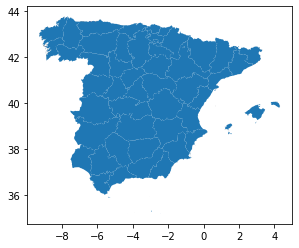

In [75]:
provincias_gdf.plot()

In [76]:
pred_X.reset_index(inplace=True)
output_data = submission_set.merge(network, on='PipeId', how='left')
output_data = output_data.merge(pred_X[['InspectionDate', 'PipeId', 'InspectionYear', 'MonthsLastRev']], on=['PipeId'], how='left')
# set indexes again to be able to re-run the model straight away
pred_X = pred_X.set_index(['PipeId', 'InspectionDate'])

output_data

,PipeId,Incidence,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,InspectionDate,InspectionYear,MonthsLastRev
0,446859944,0.082385,Valencia,Alginet,2012,PE,Gas natural,110.0,44.286,0.150,0,0,False,2021-01-01,2021,24
1,428124500,0.481281,Valencia,Alginet,2012,PE,Gas natural,160.0,110.715,0.150,2,0,False,2021-01-01,2021,23
2,438428871,0.075293,Valencia,Alginet,2012,PE,Gas natural,110.0,13.575,0.150,0,0,False,2021-01-01,2021,24
3,429034569,0.636422,Valencia,Alginet,2012,PE,Gas natural,110.0,327.689,0.150,3,0,False,2021-01-01,2021,24
4,411184477,0.198833,Valencia,Alginet,2007,PE,Gas natural,200.0,932.762,0.150,0,0,False,2021-01-01,2021,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909728,235426649,0.081943,Valencia,Paterna,2004,PE,Gas natural,110.0,7.656,0.025,0,0,False,2021-12-16,2021,23
909729,235426673,0.307003,Valencia,Paterna,2004,PE,Gas natural,110.0,4.383,0.025,2,0,False,2021-12-16,2021,23
909730,235426707,0.260331,Valencia,Paterna,2004,PE,Gas natural,110.0,2.292,0.025,1,0,False,2022-02-16,2022,25
909731,190956601,0.094811,Valencia,Paterna,2004,PE,Gas natural,90.0,87.809,4.000,0,0,False,2021-12-03,2021,23


In [77]:
mean_prob_provinces = output_data.groupby('Province').mean().Incidence
mean_prob_provinces = pd.DataFrame(mean_prob_provinces)
mean_prob_provinces.reset_index(inplace=True)
mean_prob_provinces

,Province,Incidence
0,Albacete,0.132166
1,Alicante,0.185728
2,Almeria,0.160784
3,Avila,0.438986
4,Barcelona,0.279970
5,Burgos,0.229783
6,Castellón,0.234103
7,Ciudad Real,0.279104
8,Cuenca,0.339548
9,Cádiz,0.202204


In [78]:
provincias_gdf = provincias_gdf.merge(mean_prob_provinces, left_on=['NAMEUNIT'],right_on=['Province'], how='left')
provincias_gdf = provincias_gdf.drop(['Province'], axis=1)
provincias_gdf

,NAMEUNIT,CODNUT1,CODNUT2,CODNUT3,geometry,Incidence
0,Alava,ES2,ES21,NaN,"POLYGON ((-2.76808 42.61408, -2.76863 42.61334...",NaN
1,Albacete,ES4,ES42,NaN,"POLYGON ((-2.55212 38.08501, -2.55207 38.08517...",0.132166
2,Alicante,ES5,ES52,NaN,"MULTIPOLYGON (((-0.75223 37.88691, -0.75225 37...",0.185728
3,Almería,ES6,ES61,NaN,"MULTIPOLYGON (((-3.03624 35.93791, -3.03637 35...",NaN
4,Avila,ES4,ES41,NaN,"POLYGON ((-5.43382 40.24491, -5.43430 40.24276...",0.438986
5,Badajoz,ES4,ES43,NaN,"POLYGON ((-6.81290 38.12594, -6.81314 38.12621...",NaN
6,Illes Balears,ES5,ES53,NaN,"MULTIPOLYGON (((1.24355 38.86118, 1.24360 38.8...",NaN
7,Barcelona,ES5,ES51,NaN,"MULTIPOLYGON (((1.75125 41.21822, 1.75106 41.2...",0.279970
8,Burgos,ES4,ES41,NaN,"MULTIPOLYGON (((-3.96817 41.58462, -3.96879 41...",0.229783
9,Cáceres,ES4,ES43,NaN,"POLYGON ((-6.80634 39.39066, -6.80690 39.39081...",NaN


<AxesSubplot:>

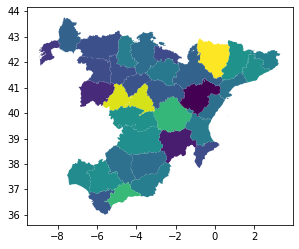

In [79]:
provincias_gdf.plot(column = 'Incidence')

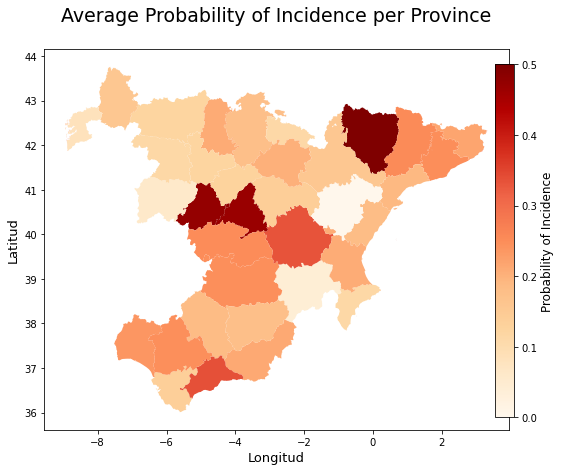

In [80]:
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111)
#Título del mapa
title = 'Average Probability of Incidence per Province'
#Impresión del título indicando un renglón entre la figura y el #texto
plt.title(title + '\n', fontsize=19)
#Impresión del mapa indicando qué marco(ax) debe tomar de referencia
provincias_gdf.plot(column='Incidence', cmap='OrRd', ax = ax)
#Nombre de los ejes horizontal y vertical
ax.set_xlabel('Longitud', fontsize = 13)
ax.set_ylabel('Latitud', fontsize = 13)
#Definición de los valores mínimo y máximo como límites de la barra #a utilizar
min_p = 0
max_p = 0.5
#Definición de la barra gráfica
bar = plt.cm.ScalarMappable(cmap='OrRd', 
norm=plt.Normalize(vmin = min_p , vmax=max_p))
#Se declara una lista donde se guardarán los valores de la barra
bar._A = []
#Declaración de la ubicación y el tamaño de la barra.
cax = plt.axes([0.85, 0.15, 0.03, 0.7]) #[xcoord, ycoord, ancho, largo]
# Impresión de la barra con las variables superiores (bar y cax)
cbar = fig.colorbar(bar, cax=cax)
#Título de la barra
cbar.set_label('Probability of Incidence', fontsize = 12)

In [81]:
output_data[output_data['Province']=='Madrid'].sort_values('InspectionDate')

,PipeId,Incidence,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,InspectionDate,InspectionYear,MonthsLastRev
429,51580752,0.230498,Madrid,Madrid,1994,PE,Gas natural,90.0,34.942,4.000,0,0,False,2021-01-01,2021,22
115253,26102313,0.325163,Madrid,Madrid,1999,AO,Gas natural,101.6,575.146,16.000,0,0,False,2021-01-01,2021,20
115252,25951686,0.250444,Madrid,Madrid,1999,AO,Gas natural,50.8,41.896,16.000,0,0,False,2021-01-01,2021,20
115250,25951409,0.361609,Madrid,Madrid,1999,AO,Gas natural,50.8,164.619,16.000,0,0,False,2021-01-01,2021,20
115168,31018284,0.376971,Madrid,Madrid,1999,AO,Gas natural,50.8,29.858,16.000,0,0,False,2021-01-01,2021,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96553,58251656,0.941626,Madrid,Meco,2020,PE,Gas natural,63.0,267.838,4.000,17,0,False,2022-12-31,2022,14
96554,58251659,0.813664,Madrid,Meco,2020,PE,Gas natural,63.0,10.589,4.000,1,0,False,2022-12-31,2022,14
464189,56468924,0.768046,Madrid,Madrid,1995,PE,Gas natural,63.0,29.852,4.000,1,0,False,2022-12-31,2022,22
237561,183189009,0.552338,Madrid,Madrid,1996,PE,Gas natural,200.0,52.369,0.025,0,0,False,2022-12-31,2022,22


In [82]:
inspections[inspections['PipeId']==186671462]

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence
211433,186671462,ZRV-00003764,2011,2011-03-18,132,3,1
